In [37]:
import pandas as pd
import numpy as np
np.set_printoptions(np.inf)
np.set_printoptions(precision=5, suppress=True)
import collections

from datetime import datetime, timedelta 

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import lightgbm as lgb
import xgboost
import optuna.integration.lightgbm as lgb_opt
from pycaret.regression import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras import optimizers

import tensorflow.compat.v1 as tf


import warnings
warnings.filterwarnings('ignore')


In [38]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [39]:
train = pd.read_csv('../input/train.csv')
# train = reduce_mem_usage(train)
train.head()

,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y
0,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,t,f,NaN,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,138.0
1,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,2016-09-12,t,t,100%,2015-12-30,f,2017-03-31,38.934810,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,42.0
2,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,2016-06-15,t,f,100%,2016-05-21,t,2017-08-13,40.695118,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN,65.0
3,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,2014-03-15,t,t,100%,2012-06-19,t,2017-09-03,37.796728,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,NaN,94133,166.0
4,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,2015-08-05,t,t,100%,2015-03-25,f,2017-09-10,40.785050,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,165.0


In [40]:
train.shape

(55583, 29)

In [41]:
test =  pd.read_csv('../input/test.csv')
# test = reduce_mem_usage(test)
test.head()

,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode
0,0,6,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",2.0,Real Bed,2.0,2.0,strict,Boston,t,Feel free to book INSTANTLY. You can check-in ...,2017-01-09,t,f,100%,2016-08-23,t,2017-09-25,42.359278,-71.069962,Gorgeous 2BR/2BA Duplex in Beacon Hill,Beacon Hill,58,House,90.0,Entire home/apt,https://a0.muscache.com/im/pictures/7e4808b4-5...,02114
1,1,3,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,moderate,LA,t,The guest house is close to: Equinox West Holl...,2016-08-17,t,t,100%,2014-09-03,f,2017-05-02,34.084747,-118.367355,Luxury 1 Bedroom West Hollywood City Center,West Hollywood,4,Guesthouse,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/5392fbd6-6...,90046
2,2,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.0,Real Bed,0.0,1.0,flexible,NYC,f,Private room in a three bedroom apartment in N...,NaN,t,t,100%,2012-10-17,f,NaN,40.720541,-73.959192,Bedroom with Patio in Prime Williamsburg Locat...,Williamsburg,0,Apartment,NaN,Private room,https://a0.muscache.com/im/pictures/544d3b89-d...,11249.0
3,3,4,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,2.0,strict,NYC,f,The apartment is located in historic Bed Stuy ...,NaN,t,t,NaN,2013-01-23,f,NaN,40.681117,-73.944091,Cozy apartment in Brooklyn,Bedford-Stuyvesant,0,Apartment,NaN,Entire home/apt,https://a0.muscache.com/im/pictures/26baf7ba-0...,11216
4,4,3,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.5,Real Bed,1.0,2.0,strict,LA,t,"Our cozy, pet friendly one bedroom apartment/l...",2015-08-01,t,t,100%,2014-12-28,f,2016-09-11,34.150995,-118.409359,"Cozy, sunny, pet friendly loft/apt",NaN,6,Loft,92.0,Entire home/apt,https://a0.muscache.com/im/pictures/86107545/9...,91604


In [42]:
test.shape

(18528, 28)

In [43]:
# r で事前作成したデータフレーム（amenitiesを分解したもの）

train_test = pd.read_csv('../input/train_test.csv')
train_test = reduce_mem_usage(train_test)
train_test.head()

Memory usage of dataframe is 87.78 MB
Memory usage after optimization is: 31.57 MB
Decreased by 64.0%


,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,TV,Wireless_Internet,Kitchen,Free_parking_on_premises,Washer,Dryer,Smoke_detector,Cable_TV,Internet,Air_conditioning,Heating,Carbon_monoxide_detector,First_aid_kit,Essentials,Shampoo,Lock_on_bedroom_door,24-hour_check-in,Hangers,Iron,Laptop_friendly_workspace,translation_missing__en.hosting_amenity_49,translation_missing__en.hosting_amenity_50,Indoor_fireplace,Buzzer_wireless_intercom,Safety_card,Fire_extinguisher,Hair_dryer,Self_Check-In,Keypad,Lockbox,Bathtub,Room-darkening_shades,Elevator,Pets_live_on_this_property,Cat_s_,Family_kid_friendly,Smart_lock,Wheelchair_accessible,Pool,Washer___Dryer,Gym,Elevator_in_building,Hot_tub,Pets_allowed,Suitable_for_events,Hot_water,Bed_linens,Microwave,Coffee_maker,Refrigerator,Dishes_and_silverware,Cooking_basics,Oven,Stove,Private_entrance,Children’s_books_and_toys,Doorman,Dog_s_,Smoking_allowed,Breakfast,Private_living_room,Extra_pillows_and_blankets,Doorman_Entry,Long_term_stays_allowed,Host_greets_you,Outlet_covers,High_chair,Pack_’n_Play_travel_crib,Children’s_dinnerware,Other_pet_s_,Smartlock,Step-free_access,Flat,_smooth_pathway_to_front_door,Beach_essentials,Dishwasher,Private_bathroom,Window_guards,Baby_bath,Hot_water_kettle,Game_console,Table_corner_guards,BBQ_grill,Patio_or_balcony,Garden_or_backyard,Luggage_dropoff_allowed,Other,Babysitter_recommendations,Handheld_shower_head,Pocket_wifi,Wide_hallway_clearance,Wide_doorway,Well-lit_path_to_entrance,Ethernet_connection,EV_charger,Single_level_home,Cleaning_before_checkout,Wide_clearance_to_bed,Accessible-height_bed,Accessible-height_toilet,Wide_clearance_to_shower_and_toilet,Wide_entryway,NA,Fixed_grab_bars_for_shower_and_toilet,Firm_mattress,Crib,Lake_access,Stair_gates,Fireplace_guards,Air_purifier,Beachfront,Path_to_entrance_lit_at_night,Waterfront,Baby_monitor,Changing_table,Free_parking_on_street,Bathtub_with_shower_chair,Ground_floor_access,Ski_in_Ski_out,Disabled_parking_spot,Firm_matress,Flat_smooth_pathway_to_front_door,Body_soap,Hand_soap,Bath_towel,Hand_or_paper_towel,Toilet_paper,Grab-rails_for_shower_and_toilet,Paid_parking_off_premises,Roll-in_shower_with_chair
0,0,6,2.0,Real Bed,1.0,4.0,flexible,LA,1.0,My place is meant for family and a few friends...,2016-07-27,True,False,NaN,2016-07-13,0.0,2016-07-27,33.78125,-118.1250,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,1.0,Real Bed,1.0,1.0,strict,DC,1.0,This is a new listing for a lovely guest bedro...,2016-09-12,True,True,100%,2015-12-30,0.0,2017-03-31,38.93750,-77.0000,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2

In [44]:
train_test.shape

(74111, 157)

In [45]:
# accommodates
train_test['accommodates'] = train_test['accommodates'].astype(float)


# bed par room
train_test['beds_per_room'] = train_test['beds'] * train_test['bedrooms']

# review date
train_test['first_review'] = train_test['first_review'].astype(str).apply(lambda x:x.replace('nan', '1999-01-01')).apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
train_test['host_since'] = train_test['host_since'].astype(str).apply(lambda x:x.replace('nan', '1999-01-01')).apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
train_test['review_date'] = (train_test['first_review'] - train_test['host_since']).apply(lambda x:x.total_seconds())

# last review date
train_test['last_review'] = train_test['last_review'].astype(str).apply(lambda x:x.replace('nan', '1999-01-01')).apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
train_test['last_review_date'] = (train_test['last_review'] - train_test['host_since']).apply(lambda x:x.total_seconds())

# keep date
train_test['keep_date'] = (train_test['last_review'] - train_test['first_review']).apply(lambda x:x.total_seconds())


# cancellation_policy
le = LabelEncoder()
le = le.fit(train_test['cancellation_policy'].astype(str))
train_test['cancellation_policy'] = le.transform(train_test['cancellation_policy'].astype(str))
train_test['cancellation_policy'] = train_test['cancellation_policy'].astype(float)



# host_response_rate
train_test['host_response_rate'] = train_test['host_response_rate'].astype(str).apply(lambda x: x.replace('%', '')).astype(float)

# neighbourhood
le = LabelEncoder()
#ラベルを覚えさせる
le = le.fit(train_test['neighbourhood'].astype(str))
#ラベルを整数に変換
train_test['neighbourhood'] = le.transform(train_test['neighbourhood'].astype(str))

# property_type
le = LabelEncoder()
le = le.fit(train_test['property_type'].astype(str))
train_test['property_type'] = le.transform(train_test['property_type'].astype(str))

# zipcode
#train_test['zipcode'] = train_test['zipcode'].astype(str).apply(lambda x : x[0:5].replace('nan', '0').replace('.', '0')).astype(int)
train_test['zipcode'] = train_test['zipcode'].astype(str).apply(lambda x : x[0:2].\
                                                                replace('na', '0').\
                                                                replace('.', '0').\
                                                                replace('1m', '0').\
                                                                replace('Ne', '0')).astype(float)


# rating
train_test['rating'] = train_test['number_of_reviews'] * train_test['review_scores_rating']

# count of nan
train_test['number_of_NAN'] = train_test.isna().sum(axis=1).astype(np.int8)

In [46]:
train_test['review_scores_rating_qcut_10'] = pd.qcut(train_test['review_scores_rating'], 10, duplicates='drop').astype(str)

In [47]:
# 特徴量同士を結合した特徴量を作成し Label Encoding
def conb_enc(col1, col2, df_train_test):
    new_col = col1 + '_' + col2
    #df_train[new_col] = df_train[col1].astype(str) + '_' + df_train[col2].astype(str)
    df_train_test[new_col] = df_train_test[col1].astype(str) + '_' + df_train_test[col2].astype(str) 
    le = LabelEncoder()
    le.fit(list(df_train_test[new_col].astype(str).values) )
    df_train_test[new_col] = le.transform(list(df_train_test[new_col].astype(str).values))
    return(df_train_test)
    #df_train_test[new_col] = le.transform(list(df_train_test[new_col].astype(str).values)) 

In [48]:
train_test = conb_enc('city', 'property_type', train_test)

In [49]:
train_test = conb_enc('bed_type', 'beds', train_test)

In [50]:
train_test = conb_enc('bed_type', 'bedrooms', train_test)

In [51]:
train_test['len_description'] = train_test['description'].apply(lambda x: len(x))

In [52]:
train_test['bath_bed'] = train_test['bathrooms'] + train_test['beds']

In [53]:
train_test['thumbnail_url'] = train_test['thumbnail_url'].isnull()

In [54]:
train_test.head()

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,TV,Wireless_Internet,Kitchen,Free_parking_on_premises,Washer,Dryer,Smoke_detector,Cable_TV,Internet,Air_conditioning,Heating,Carbon_monoxide_detector,First_aid_kit,Essentials,Shampoo,Lock_on_bedroom_door,24-hour_check-in,Hangers,Iron,Laptop_friendly_workspace,translation_missing__en.hosting_amenity_49,translation_missing__en.hosting_amenity_50,Indoor_fireplace,Buzzer_wireless_intercom,Safety_card,Fire_extinguisher,Hair_dryer,Self_Check-In,Keypad,Lockbox,Bathtub,Room-darkening_shades,Elevator,Pets_live_on_this_property,Cat_s_,Family_kid_friendly,Smart_lock,Wheelchair_accessible,Pool,Washer___Dryer,Gym,Elevator_in_building,Hot_tub,Pets_allowed,Suitable_for_events,Hot_water,Bed_linens,Microwave,Coffee_maker,Refrigerator,Dishes_and_silverware,Cooking_basics,Oven,Stove,Private_entrance,Children’s_books_and_toys,Doorman,Dog_s_,Smoking_allowed,Breakfast,Private_living_room,Extra_pillows_and_blankets,Doorman_Entry,Long_term_stays_allowed,Host_greets_you,Outlet_covers,High_chair,Pack_’n_Play_travel_crib,Children’s_dinnerware,Other_pet_s_,Smartlock,Step-free_access,Flat,_smooth_pathway_to_front_door,Beach_essentials,Dishwasher,Private_bathroom,Window_guards,Baby_bath,Hot_water_kettle,Game_console,Table_corner_guards,BBQ_grill,Patio_or_balcony,Garden_or_backyard,Luggage_dropoff_allowed,Other,Babysitter_recommendations,Handheld_shower_head,Pocket_wifi,Wide_hallway_clearance,Wide_doorway,Well-lit_path_to_entrance,Ethernet_connection,EV_charger,Single_level_home,Cleaning_before_checkout,Wide_clearance_to_bed,Accessible-height_bed,Accessible-height_toilet,Wide_clearance_to_shower_and_toilet,Wide_entryway,NA,Fixed_grab_bars_for_shower_and_toilet,Firm_mattress,Crib,Lake_access,Stair_gates,Fireplace_guards,Air_purifier,Beachfront,Path_to_entrance_lit_at_night,Waterfront,Baby_monitor,Changing_table,Free_parking_on_street,Bathtub_with_shower_chair,Ground_floor_access,Ski_in_Ski_out,Disabled_parking_spot,Firm_matress,Flat_smooth_pathway_to_front_door,Body_soap,Hand_soap,Bath_towel,Hand_or_paper_towel,Toilet_paper,Grab-rails_for_shower_and_toilet,Paid_parking_off_premises,Roll-in_shower_with_chair,beds_per_room,review_date,last_review_date,keep_date,rating,number_of_NAN,review_scores_rating_qcut_10,city_property_type,bed_type_beds,bed_type_bedrooms,len_description,bath_bed
0,0,6.0,2.0,Real Bed,1.0,4.0,0.0,LA,1.0,My place is meant for family and a few friends...,2016-07-27,True,False,NaN,2016-07-13,0.0,2016-07-27,33.78125,-118.1250,The Penthouse,619,1,0,60.0,Private room,True,90.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1209600.0,1209600.0,0.0,60.0,125,"(19.999, 86.0]",55,35,22,379,6.0
1,1,2.0,1.0,Real Bed,1.0,1.0,2.0,DC,1.0,This is a new listing for a lovely guest bedro...,2016-09-12,True,True,100.0,2015-12-30,0.0,2017-03-31,38.93750,-77.0000,Guest Bedroom in Brookland,74,9,17,100.0,Private room,False,20.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [55]:
train_test.shape

(74111, 169)

In [56]:
train_test_fin = train_test.drop([
                 'id', 
#                'accommodates',
#                'amenities', 
#                'bathrooms', 
#                'bed_type',
#                'bedrooms',
#                'beds', 
#                'cancellation_policy', 
#                'city',
#                'cleaning_fee', 
                 'description',
#                'first_review', 
#                'host_has_profile_pic', 
#                'host_identity_verified',
#                'host_response_rate',
#                'host_since', 
#                'instant_bookable', 
#                'last_review',
#                'latitude', 
#                'longitude', 
                 'name', 
#                'neighbourhood',
#                'number_of_reviews',
#                'property_type', 
#                'review_scores_rating', 
#                'room_type',
#                'thumbnail_url', 
#                'zipcode',
#                'number_of_NAN',
                 'review_scores_rating_qcut_10'], axis = 1)

In [57]:
train_test_fin.head()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,TV,Wireless_Internet,Kitchen,Free_parking_on_premises,Washer,Dryer,Smoke_detector,Cable_TV,Internet,Air_conditioning,Heating,Carbon_monoxide_detector,First_aid_kit,Essentials,Shampoo,Lock_on_bedroom_door,24-hour_check-in,Hangers,Iron,Laptop_friendly_workspace,translation_missing__en.hosting_amenity_49,translation_missing__en.hosting_amenity_50,Indoor_fireplace,Buzzer_wireless_intercom,Safety_card,Fire_extinguisher,Hair_dryer,Self_Check-In,Keypad,Lockbox,Bathtub,Room-darkening_shades,Elevator,Pets_live_on_this_property,Cat_s_,Family_kid_friendly,Smart_lock,Wheelchair_accessible,Pool,Washer___Dryer,Gym,Elevator_in_building,Hot_tub,Pets_allowed,Suitable_for_events,Hot_water,Bed_linens,Microwave,Coffee_maker,Refrigerator,Dishes_and_silverware,Cooking_basics,Oven,Stove,Private_entrance,Children’s_books_and_toys,Doorman,Dog_s_,Smoking_allowed,Breakfast,Private_living_room,Extra_pillows_and_blankets,Doorman_Entry,Long_term_stays_allowed,Host_greets_you,Outlet_covers,High_chair,Pack_’n_Play_travel_crib,Children’s_dinnerware,Other_pet_s_,Smartlock,Step-free_access,Flat,_smooth_pathway_to_front_door,Beach_essentials,Dishwasher,Private_bathroom,Window_guards,Baby_bath,Hot_water_kettle,Game_console,Table_corner_guards,BBQ_grill,Patio_or_balcony,Garden_or_backyard,Luggage_dropoff_allowed,Other,Babysitter_recommendations,Handheld_shower_head,Pocket_wifi,Wide_hallway_clearance,Wide_doorway,Well-lit_path_to_entrance,Ethernet_connection,EV_charger,Single_level_home,Cleaning_before_checkout,Wide_clearance_to_bed,Accessible-height_bed,Accessible-height_toilet,Wide_clearance_to_shower_and_toilet,Wide_entryway,NA,Fixed_grab_bars_for_shower_and_toilet,Firm_mattress,Crib,Lake_access,Stair_gates,Fireplace_guards,Air_purifier,Beachfront,Path_to_entrance_lit_at_night,Waterfront,Baby_monitor,Changing_table,Free_parking_on_street,Bathtub_with_shower_chair,Ground_floor_access,Ski_in_Ski_out,Disabled_parking_spot,Firm_matress,Flat_smooth_pathway_to_front_door,Body_soap,Hand_soap,Bath_towel,Hand_or_paper_towel,Toilet_paper,Grab-rails_for_shower_and_toilet,Paid_parking_off_premises,Roll-in_shower_with_chair,beds_per_room,review_date,last_review_date,keep_date,rating,number_of_NAN,city_property_type,bed_type_beds,bed_type_bedrooms,len_description,bath_bed
0,6.0,2.0,Real Bed,1.0,4.0,0.0,LA,1.0,2016-07-27,True,False,NaN,2016-07-13,0.0,2016-07-27,33.78125,-118.1250,619,1,0,60.0,Private room,True,90.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1209600.0,1209600.0,0.0,60.0,125,55,35,22,379,6.0
1,2.0,1.0,Real Bed,1.0,1.0,2.0,DC,1.0,2016-09-12,True,True,100.0,2015-12-30,0.0,2017-03-31,38.93750,-77.0000,74,9,17,100.0,Private room,False,20.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,22204800.0,39484800.0,172800

In [58]:
categ = ['bed_type', 'city', 'cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'room_type', 'thumbnail_url']#, 'review_scores_rating_qcut_10']
le= LabelEncoder()
train_test_fin[categ]= train_test_fin[categ].apply(le.fit_transform)

In [59]:
dates = ['first_review', 'host_since', 'last_review']

train_test_fin[dates] = train_test_fin[dates].apply(lambda x : x.apply(lambda x : x.strftime('%Y%m%d')).astype(float))

In [60]:
train_test_fin.head()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,TV,Wireless_Internet,Kitchen,Free_parking_on_premises,Washer,Dryer,Smoke_detector,Cable_TV,Internet,Air_conditioning,Heating,Carbon_monoxide_detector,First_aid_kit,Essentials,Shampoo,Lock_on_bedroom_door,24-hour_check-in,Hangers,Iron,Laptop_friendly_workspace,translation_missing__en.hosting_amenity_49,translation_missing__en.hosting_amenity_50,Indoor_fireplace,Buzzer_wireless_intercom,Safety_card,Fire_extinguisher,Hair_dryer,Self_Check-In,Keypad,Lockbox,Bathtub,Room-darkening_shades,Elevator,Pets_live_on_this_property,Cat_s_,Family_kid_friendly,Smart_lock,Wheelchair_accessible,Pool,Washer___Dryer,Gym,Elevator_in_building,Hot_tub,Pets_allowed,Suitable_for_events,Hot_water,Bed_linens,Microwave,Coffee_maker,Refrigerator,Dishes_and_silverware,Cooking_basics,Oven,Stove,Private_entrance,Children’s_books_and_toys,Doorman,Dog_s_,Smoking_allowed,Breakfast,Private_living_room,Extra_pillows_and_blankets,Doorman_Entry,Long_term_stays_allowed,Host_greets_you,Outlet_covers,High_chair,Pack_’n_Play_travel_crib,Children’s_dinnerware,Other_pet_s_,Smartlock,Step-free_access,Flat,_smooth_pathway_to_front_door,Beach_essentials,Dishwasher,Private_bathroom,Window_guards,Baby_bath,Hot_water_kettle,Game_console,Table_corner_guards,BBQ_grill,Patio_or_balcony,Garden_or_backyard,Luggage_dropoff_allowed,Other,Babysitter_recommendations,Handheld_shower_head,Pocket_wifi,Wide_hallway_clearance,Wide_doorway,Well-lit_path_to_entrance,Ethernet_connection,EV_charger,Single_level_home,Cleaning_before_checkout,Wide_clearance_to_bed,Accessible-height_bed,Accessible-height_toilet,Wide_clearance_to_shower_and_toilet,Wide_entryway,NA,Fixed_grab_bars_for_shower_and_toilet,Firm_mattress,Crib,Lake_access,Stair_gates,Fireplace_guards,Air_purifier,Beachfront,Path_to_entrance_lit_at_night,Waterfront,Baby_monitor,Changing_table,Free_parking_on_street,Bathtub_with_shower_chair,Ground_floor_access,Ski_in_Ski_out,Disabled_parking_spot,Firm_matress,Flat_smooth_pathway_to_front_door,Body_soap,Hand_soap,Bath_towel,Hand_or_paper_towel,Toilet_paper,Grab-rails_for_shower_and_toilet,Paid_parking_off_premises,Roll-in_shower_with_chair,beds_per_room,review_date,last_review_date,keep_date,rating,number_of_NAN,city_property_type,bed_type_beds,bed_type_bedrooms,len_description,bath_bed
0,6.0,2.0,4,1.0,4.0,0.0,3,1,20160727.0,2,0,NaN,20160713.0,0,20160727.0,33.78125,-118.1250,619,1,0,60.0,1,1,90.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1209600.0,1209600.0,0.0,60.0,125,55,35,22,379,6.0
1,2.0,1.0,4,1.0,1.0,2.0,2,1,20160912.0,2,1,100.0,20151230.0,0,20170331.0,38.93750,-77.0000,74,9,17,100.0,1,0,20.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,22204800.0,39484800.0,17280000.0,900.0,108,41,24,22,406,2.0
2,2.0,2.0,4,1.0,1.0,2.0,4,1,201606

In [61]:
train_test_fin.info(all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 165 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   accommodates                                float64
 1   bathrooms                                   float16
 2   bed_type                                    int64  
 3   bedrooms                                    float16
 4   beds                                        float16
 5   cancellation_policy                         float64
 6   city                                        int64  
 7   cleaning_fee                                int64  
 8   first_review                                float64
 9   host_has_profile_pic                        int64  
 10  host_identity_verified                      int64  
 11  host_response_rate                          float64
 12  host_since                                  float64
 13  instant_bookable              

In [62]:
reduce_mem_usage(train_test_fin)

Memory usage of dataframe is 33.57 MB
Memory usage after optimization is: 23.39 MB
Decreased by 30.3%


,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,TV,Wireless_Internet,Kitchen,Free_parking_on_premises,Washer,Dryer,Smoke_detector,Cable_TV,Internet,Air_conditioning,Heating,Carbon_monoxide_detector,First_aid_kit,Essentials,Shampoo,Lock_on_bedroom_door,24-hour_check-in,Hangers,Iron,Laptop_friendly_workspace,translation_missing__en.hosting_amenity_49,translation_missing__en.hosting_amenity_50,Indoor_fireplace,Buzzer_wireless_intercom,Safety_card,Fire_extinguisher,Hair_dryer,Self_Check-In,Keypad,Lockbox,Bathtub,Room-darkening_shades,Elevator,Pets_live_on_this_property,Cat_s_,Family_kid_friendly,Smart_lock,Wheelchair_accessible,Pool,Washer___Dryer,Gym,Elevator_in_building,Hot_tub,Pets_allowed,Suitable_for_events,Hot_water,Bed_linens,Microwave,Coffee_maker,Refrigerator,Dishes_and_silverware,Cooking_basics,Oven,Stove,Private_entrance,Children’s_books_and_toys,Doorman,Dog_s_,Smoking_allowed,Breakfast,Private_living_room,Extra_pillows_and_blankets,Doorman_Entry,Long_term_stays_allowed,Host_greets_you,Outlet_covers,High_chair,Pack_’n_Play_travel_crib,Children’s_dinnerware,Other_pet_s_,Smartlock,Step-free_access,Flat,_smooth_pathway_to_front_door,Beach_essentials,Dishwasher,Private_bathroom,Window_guards,Baby_bath,Hot_water_kettle,Game_console,Table_corner_guards,BBQ_grill,Patio_or_balcony,Garden_or_backyard,Luggage_dropoff_allowed,Other,Babysitter_recommendations,Handheld_shower_head,Pocket_wifi,Wide_hallway_clearance,Wide_doorway,Well-lit_path_to_entrance,Ethernet_connection,EV_charger,Single_level_home,Cleaning_before_checkout,Wide_clearance_to_bed,Accessible-height_bed,Accessible-height_toilet,Wide_clearance_to_shower_and_toilet,Wide_entryway,NA,Fixed_grab_bars_for_shower_and_toilet,Firm_mattress,Crib,Lake_access,Stair_gates,Fireplace_guards,Air_purifier,Beachfront,Path_to_entrance_lit_at_night,Waterfront,Baby_monitor,Changing_table,Free_parking_on_street,Bathtub_with_shower_chair,Ground_floor_access,Ski_in_Ski_out,Disabled_parking_spot,Firm_matress,Flat_smooth_pathway_to_front_door,Body_soap,Hand_soap,Bath_towel,Hand_or_paper_towel,Toilet_paper,Grab-rails_for_shower_and_toilet,Paid_parking_off_premises,Roll-in_shower_with_chair,beds_per_room,review_date,last_review_date,keep_date,rating,number_of_NAN,city_property_type,bed_type_beds,bed_type_bedrooms,len_description,bath_bed
0,6.0,2.0,4,1.0,4.0,0.0,3,1,20160728.0,2,0,NaN,20160712.0,0,20160728.0,33.78125,-118.1250,619,1,0,60.0,1,1,90.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1209600.0,1209600.0,0.0,60.0,125,55,35,22,379,6.0
1,2.0,1.0,4,1.0,1.0,2.0,2,1,20160912.0,2,1,100.0,20151230.0,0,20170332.0,38.93750,-77.0000,74,9,17,100.0,1,0,20.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,22204800.0,39484800.0,17280000.0,900.0,108,41,24,22,406,2.0
2,2.0,2.0,4,1.0,1.0,2.0,4,1,201606

In [63]:
train_x = train_test_fin.iloc[0:55583,:]
train_y = train['y']
test_x = train_test_fin.iloc[55583:,:]

In [64]:
test_x.info(all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18528 entries, 55583 to 74110
Data columns (total 165 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   accommodates                                float16
 1   bathrooms                                   float16
 2   bed_type                                    int8   
 3   bedrooms                                    float16
 4   beds                                        float16
 5   cancellation_policy                         float16
 6   city                                        int8   
 7   cleaning_fee                                int8   
 8   first_review                                float32
 9   host_has_profile_pic                        int8   
 10  host_identity_verified                      int8   
 11  host_response_rate                          float16
 12  host_since                                  float32
 13  instant_bookable          

In [65]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)

(55583, 165)
(55583,)
(18528, 165)


In [66]:
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [67]:
lgb_train = lgb_opt.Dataset(X_train, y_train)
lgb_valid = lgb_opt.Dataset(X_valid, y_valid, reference=lgb_opt)

In [68]:
lgb_params = {
        'objective': 'regression',
        'metric': 'rmse'
    }

In [69]:
# Optuna でハイパーパラメータを Stepwise Optimization する
tuned_booster = lgb_opt.train(lgb_params, 
                          lgb_train,
                          valid_sets=lgb_valid,
                          num_boost_round=100,
                          early_stopping_rounds=40,
                          verbose_eval=10,
                          )

[I 2021-07-25 19:41:33,924] A new study created in memory with name: no-name-f0077fda-098b-44a8-a3c8-0a7064fc65ba

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 122.775
[20]	valid_0's rmse: 111.692
[30]	valid_0's rmse: 107.621
[40]	valid_0's rmse: 106.17
[50]	valid_0's rmse: 105.213
[60]	valid_0's rmse: 104.508
[70]	valid_0's rmse: 104.003
[80]	valid_0's rmse: 103.744
[90]	valid_0's rmse: 103.467



feature_fraction, val_score: 103.185204:  14%|#4        | 1/7 [00:15<01:35, 15.99s/it][I 2021-07-25 19:41:49,938] Trial 0 finished with value: 103.18520360733775 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 103.18520360733775.

feature_fraction, val_score: 103.185204:  14%|#4        | 1/7 [00:16<01:35, 15.99s/it]

[100]	valid_0's rmse: 103.185
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 103.185
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.249709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 120.674
[20]	valid_0's rmse: 111.068
[30]	valid_0's rmse: 107.716
[40]	valid_0's rmse: 105.915
[50]	valid_0's rmse: 104.986
[60]	valid_0's rmse: 104.271
[70]	valid_0's rmse: 104.037
[80]	valid_0's rmse: 103.611
[90]	valid_0's rmse: 103.436



feature_fraction, val_score: 103.185204:  29%|##8       | 2/7 [00:32<01:20, 16.01s/it][I 2021-07-25 19:42:05,994] Trial 1 finished with value: 103.33325017654022 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 103.18520360733775.

feature_fraction, val_score: 103.185204:  29%|##8       | 2/7 [00:32<01:20, 16.01s/it]

[100]	valid_0's rmse: 103.348
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 103.333
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 121.156
[20]	valid_0's rmse: 111.909
[30]	valid_0's rmse: 108.398
[40]	valid_0's rmse: 106.663
[50]	valid_0's rmse: 105.814
[60]	valid_0's rmse: 105.088
[70]	valid_0's rmse: 104.573
[80]	valid_0's rmse: 104.208
[90]	valid_0's rmse: 104.043



feature_fraction, val_score: 103.185204:  43%|####2     | 3/7 [00:49<01:05, 16.35s/it][I 2021-07-25 19:42:23,129] Trial 2 finished with value: 103.84411863105271 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 103.18520360733775.

feature_fraction, val_score: 103.185204:  43%|####2     | 3/7 [00:49<01:05, 16.35s/it]

[100]	valid_0's rmse: 103.846
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 103.844
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.303339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 120.78
[20]	valid_0's rmse: 111.945
[30]	valid_0's rmse: 108.176
[40]	valid_0's rmse: 106.417
[50]	valid_0's rmse: 105.424
[60]	valid_0's rmse: 104.72
[70]	valid_0's rmse: 104.326
[80]	valid_0's rmse: 104.021
[90]	valid_0's rmse: 103.809



feature_fraction, val_score: 103.185204:  57%|#####7    | 4/7 [01:00<00:44, 14.87s/it][I 2021-07-25 19:42:34,560] Trial 3 finished with value: 103.7378569701839 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 103.18520360733775.

feature_fraction, val_score: 103.185204:  57%|#####7    | 4/7 [01:00<00:44, 14.87s/it]

[100]	valid_0's rmse: 103.738
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 103.738
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 124.782
[20]	valid_0's rmse: 113.701
[30]	valid_0's rmse: 109.06
[40]	valid_0's rmse: 107.001
[50]	valid_0's rmse: 105.701
[60]	valid_0's rmse: 105.22
[70]	valid_0's rmse: 104.604
[80]	valid_0's rmse: 104.121



feature_fraction, val_score: 103.185204:  71%|#######1  | 5/7 [01:02<00:21, 10.97s/it][I 2021-07-25 19:42:36,426] Trial 4 finished with value: 103.78204892098026 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 103.18520360733775.

feature_fraction, val_score: 103.185204:  71%|#######1  | 5/7 [01:02<00:21, 10.97s/it]

[90]	valid_0's rmse: 104.014
[100]	valid_0's rmse: 103.782
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 103.782
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 120.98
[20]	valid_0's rmse: 111.656
[30]	valid_0's rmse: 108.04
[40]	valid_0's rmse: 106.376
[50]	valid_0's rmse: 105.276
[60]	valid_0's rmse: 104.889
[70]	valid_0's rmse: 104.522
[80]	valid_0's rmse: 104.27
[90]	valid_0's rmse: 103.928



feature_fraction, val_score: 103.185204:  86%|########5 | 6/7 [01:04<00:08,  8.34s/it][I 2021-07-25 19:42:38,636] Trial 5 finished with value: 103.87012473793492 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 103.18520360733775.

feature_fraction, val_score: 103.185204:  86%|########5 | 6/7 [01:04<00:08,  8.34s/it]

[100]	valid_0's rmse: 103.87
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 103.87
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 120.801
[20]	valid_0's rmse: 111.268
[30]	valid_0's rmse: 107.756
[40]	valid_0's rmse: 106.02
[50]	valid_0's rmse: 105.055
[60]	valid_0's rmse: 104.531
[70]	valid_0's rmse: 104.154
[80]	valid_0's rmse: 103.976
[90]	valid_0's rmse: 103.837



feature_fraction, val_score: 103.185204: 100%|##########| 7/7 [01:06<00:00,  9.53s/it]

num_leaves, val_score: 103.185204:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	valid_0's rmse: 103.683
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 103.683
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.52
[20]	valid_0's rmse: 107.431
[30]	valid_0's rmse: 104.602
[40]	valid_0's rmse: 103.985
[50]	valid_0's rmse: 103.224
[60]	valid_0's rmse: 102.97
[70]	valid_0's rmse: 102.818
[80]	valid_0's rmse: 102.679
[90]	valid_0's rmse: 102.722



num_leaves, val_score: 102.622322:   5%|5         | 1/20 [00:36<11:34, 36.53s/it][I 2021-07-25 19:43:17,214] Trial 7 finished with value: 102.62232244004323 and parameters: {'num_leaves': 152}. Best is trial 7 with value: 102.62232244004323.

num_leaves, val_score: 102.622322:   5%|5         | 1/20 [00:36<11:34, 36.53s/it]

[100]	valid_0's rmse: 102.628
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 102.622
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.028
[20]	valid_0's rmse: 107.585
[30]	valid_0's rmse: 104.598
[40]	valid_0's rmse: 103.712
[50]	valid_0's rmse: 102.888
[60]	valid_0's rmse: 102.649
[70]	valid_0's rmse: 102.269
[80]	valid_0's rmse: 102.238
[90]	valid_0's rmse: 102.044



num_leaves, val_score: 102.031548:  10%|#         | 2/20 [01:29<12:28, 41.57s/it][I 2021-07-25 19:44:10,523] Trial 8 finished with value: 102.03154823267802 and parameters: {'num_leaves': 124}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  10%|#         | 2/20 [01:29<12:28, 41.57s/it]

[100]	valid_0's rmse: 102.043
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 102.032
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.038
[20]	valid_0's rmse: 107.933
[30]	valid_0's rmse: 104.77
[40]	valid_0's rmse: 103.729
[50]	valid_0's rmse: 102.939
[60]	valid_0's rmse: 102.475
[70]	valid_0's rmse: 102.235
[80]	valid_0's rmse: 102.039
[90]	valid_0's rmse: 102.175



num_leaves, val_score: 102.031548:  15%|#5        | 3/20 [01:37<08:53, 31.37s/it][I 2021-07-25 19:44:18,093] Trial 9 finished with value: 102.03877789099467 and parameters: {'num_leaves': 112}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  15%|#5        | 3/20 [01:37<08:53, 31.37s/it]

[100]	valid_0's rmse: 102.154
Did not meet early stopping. Best iteration is:
[80]	valid_0's rmse: 102.039
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 129.038
[20]	valid_0's rmse: 117.857
[30]	valid_0's rmse: 113.003
[40]	valid_0's rmse: 110.766
[50]	valid_0's rmse: 109.267
[60]	valid_0's rmse: 108.435
[70]	valid_0's rmse: 107.626
[80]	valid_0's rmse: 107.12
[90]	valid_0's rmse: 106.586



num_leaves, val_score: 102.031548:  20%|##        | 4/20 [01:49<06:48, 25.56s/it][I 2021-07-25 19:44:30,091] Trial 10 finished with value: 106.25229202691784 and parameters: {'num_leaves': 10}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  20%|##        | 4/20 [01:49<06:48, 25.56s/it]

[100]	valid_0's rmse: 106.252
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 106.252
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.861
[20]	valid_0's rmse: 108.85
[30]	valid_0's rmse: 105.454
[40]	valid_0's rmse: 104.236
[50]	valid_0's rmse: 103.177
[60]	valid_0's rmse: 102.832
[70]	valid_0's rmse: 102.345
[80]	valid_0's rmse: 102.293
[90]	valid_0's rmse: 102.237



num_leaves, val_score: 102.031548:  25%|##5       | 5/20 [02:21<06:53, 27.59s/it][I 2021-07-25 19:45:02,416] Trial 11 finished with value: 102.1093470618186 and parameters: {'num_leaves': 93}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  25%|##5       | 5/20 [02:21<06:53, 27.59s/it]

[100]	valid_0's rmse: 102.125
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 102.109
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.592
[20]	valid_0's rmse: 108.469
[30]	valid_0's rmse: 105.151
[40]	valid_0's rmse: 104.076
[50]	valid_0's rmse: 103.371
[60]	valid_0's rmse: 102.998
[70]	valid_0's rmse: 102.847
[80]	valid_0's rmse: 102.66
[90]	valid_0's rmse: 102.589



num_leaves, val_score: 102.031548:  30%|###       | 6/20 [02:53<06:44, 28.86s/it][I 2021-07-25 19:45:34,254] Trial 12 finished with value: 102.57711436851116 and parameters: {'num_leaves': 102}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  30%|###       | 6/20 [02:53<06:44, 28.86s/it]

[100]	valid_0's rmse: 102.577
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 102.577
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.067
[20]	valid_0's rmse: 107.254
[30]	valid_0's rmse: 104.626
[40]	valid_0's rmse: 104.145
[50]	valid_0's rmse: 103.523
[60]	valid_0's rmse: 103.474
[70]	valid_0's rmse: 103.205
[80]	valid_0's rmse: 103.285
[90]	valid_0's rmse: 103.28



num_leaves, val_score: 102.031548:  35%|###5      | 7/20 [03:49<08:00, 36.98s/it][I 2021-07-25 19:46:30,173] Trial 13 finished with value: 103.12780646319662 and parameters: {'num_leaves': 238}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  35%|###5      | 7/20 [03:49<08:00, 36.98s/it]

[100]	valid_0's rmse: 103.266
Did not meet early stopping. Best iteration is:
[73]	valid_0's rmse: 103.128
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.484
[20]	valid_0's rmse: 107.371
[30]	valid_0's rmse: 104.577
[40]	valid_0's rmse: 103.639
[50]	valid_0's rmse: 103.198
[60]	valid_0's rmse: 103.047
[70]	valid_0's rmse: 102.853
[80]	valid_0's rmse: 102.641
[90]	valid_0's rmse: 102.673



num_leaves, val_score: 102.031548:  40%|####      | 8/20 [04:16<06:48, 34.04s/it][I 2021-07-25 19:46:57,363] Trial 14 finished with value: 102.54780149178937 and parameters: {'num_leaves': 162}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  40%|####      | 8/20 [04:16<06:48, 34.04s/it]

[100]	valid_0's rmse: 102.548
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 102.548
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 119.781
[20]	valid_0's rmse: 109.596
[30]	valid_0's rmse: 105.867
[40]	valid_0's rmse: 105.059
[50]	valid_0's rmse: 103.915
[60]	valid_0's rmse: 103.375
[70]	valid_0's rmse: 103.119
[80]	valid_0's rmse: 103.04
[90]	valid_0's rmse: 102.96



num_leaves, val_score: 102.031548:  45%|####5     | 9/20 [04:33<05:18, 28.92s/it][I 2021-07-25 19:47:14,335] Trial 15 finished with value: 102.8230176326968 and parameters: {'num_leaves': 67}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  45%|####5     | 9/20 [04:33<05:18, 28.92s/it]

[100]	valid_0's rmse: 102.823
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 102.823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.184
[20]	valid_0's rmse: 107.346
[30]	valid_0's rmse: 104.571
[40]	valid_0's rmse: 103.697
[50]	valid_0's rmse: 102.776
[60]	valid_0's rmse: 102.69
[70]	valid_0's rmse: 102.468
[80]	valid_0's rmse: 102.268
[90]	valid_0's rmse: 102.33



num_leaves, val_score: 102.031548:  50%|#####     | 10/20 [05:23<05:52, 35.25s/it][I 2021-07-25 19:48:04,339] Trial 16 finished with value: 102.21534613460709 and parameters: {'num_leaves': 190}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  50%|#####     | 10/20 [05:23<05:52, 35.25s/it]

[100]	valid_0's rmse: 102.249
Did not meet early stopping. Best iteration is:
[82]	valid_0's rmse: 102.215
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 121.48
[20]	valid_0's rmse: 110.734
[30]	valid_0's rmse: 106.942
[40]	valid_0's rmse: 105.591
[50]	valid_0's rmse: 104.616
[60]	valid_0's rmse: 103.978
[70]	valid_0's rmse: 103.512
[80]	valid_0's rmse: 103.322
[90]	valid_0's rmse: 103.079



num_leaves, val_score: 102.031548:  55%|#####5    | 11/20 [05:40<04:27, 29.69s/it][I 2021-07-25 19:48:21,054] Trial 17 finished with value: 102.90274975891168 and parameters: {'num_leaves': 42}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  55%|#####5    | 11/20 [05:40<04:27, 29.69s/it]

[100]	valid_0's rmse: 102.903
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 102.903
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.068
[20]	valid_0's rmse: 107.942
[30]	valid_0's rmse: 104.975
[40]	valid_0's rmse: 103.884
[50]	valid_0's rmse: 103.287
[60]	valid_0's rmse: 103.052
[70]	valid_0's rmse: 102.688
[80]	valid_0's rmse: 102.428
[90]	valid_0's rmse: 102.257



num_leaves, val_score: 102.031548:  60%|######    | 12/20 [06:01<03:37, 27.15s/it][I 2021-07-25 19:48:42,284] Trial 18 finished with value: 102.16240721244655 and parameters: {'num_leaves': 122}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  60%|######    | 12/20 [06:01<03:37, 27.15s/it]

[100]	valid_0's rmse: 102.162
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 102.162
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.505
[20]	valid_0's rmse: 107.62
[30]	valid_0's rmse: 104.962
[40]	valid_0's rmse: 104.165
[50]	valid_0's rmse: 103.458
[60]	valid_0's rmse: 103.04
[70]	valid_0's rmse: 102.939
[80]	valid_0's rmse: 102.922
[90]	valid_0's rmse: 102.911



num_leaves, val_score: 102.031548:  65%|######5   | 13/20 [06:06<02:23, 20.45s/it][I 2021-07-25 19:48:47,102] Trial 19 finished with value: 102.8565109895254 and parameters: {'num_leaves': 169}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  65%|######5   | 13/20 [06:06<02:23, 20.45s/it]

[100]	valid_0's rmse: 102.88
Did not meet early stopping. Best iteration is:
[71]	valid_0's rmse: 102.857
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.179
[20]	valid_0's rmse: 107.296
[30]	valid_0's rmse: 104.667
[40]	valid_0's rmse: 103.917
[50]	valid_0's rmse: 103.219
[60]	valid_0's rmse: 103.045
[70]	valid_0's rmse: 102.862
[80]	valid_0's rmse: 102.846
[90]	valid_0's rmse: 102.683



num_leaves, val_score: 102.031548:  70%|#######   | 14/20 [06:12<01:36, 16.02s/it][I 2021-07-25 19:48:52,774] Trial 20 finished with value: 102.5256861267248 and parameters: {'num_leaves': 226}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  70%|#######   | 14/20 [06:12<01:36, 16.02s/it]

[100]	valid_0's rmse: 102.561
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 102.526
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.861
[20]	valid_0's rmse: 108.85
[30]	valid_0's rmse: 105.454
[40]	valid_0's rmse: 104.236
[50]	valid_0's rmse: 103.177
[60]	valid_0's rmse: 102.832
[70]	valid_0's rmse: 102.345
[80]	valid_0's rmse: 102.293


[90]	valid_0's rmse: 102.237
[100]	valid_0's rmse: 102.125
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 102.109


num_leaves, val_score: 102.031548:  75%|#######5  | 15/20 [06:14<01:00, 12.05s/it][I 2021-07-25 19:48:55,557] Trial 21 finished with value: 102.1093470618186 and parameters: {'num_leaves': 93}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  75%|#######5  | 15/20 [06:14<01:00, 12.05s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 119.544
[20]	valid_0's rmse: 109.206
[30]	valid_0's rmse: 105.666
[40]	valid_0's rmse: 104.612
[50]	valid_0's rmse: 103.812
[60]	valid_0's rmse: 103.305
[70]	valid_0's rmse: 102.926
[80]	valid_0's rmse: 102.598



num_leaves, val_score: 102.031548:  80%|########  | 16/20 [06:17<00:36,  9.20s/it][I 2021-07-25 19:48:58,123] Trial 22 finished with value: 102.35424094102879 and parameters: {'num_leaves': 75}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  80%|########  | 16/20 [06:17<00:36,  9.20s/it]

[90]	valid_0's rmse: 102.554
[100]	valid_0's rmse: 102.354
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 102.354
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.083
[20]	valid_0's rmse: 108
[30]	valid_0's rmse: 104.998
[40]	valid_0's rmse: 103.917
[50]	valid_0's rmse: 103.264
[60]	valid_0's rmse: 102.813
[70]	valid_0's rmse: 102.616
[80]	valid_0's rmse: 102.486
[90]	valid_0's rmse: 102.396



num_leaves, val_score: 102.031548:  85%|########5 | 17/20 [06:20<00:22,  7.47s/it][I 2021-07-25 19:49:01,557] Trial 23 finished with value: 102.30467533422987 and parameters: {'num_leaves': 126}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  85%|########5 | 17/20 [06:20<00:22,  7.47s/it]

[100]	valid_0's rmse: 102.305
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 102.305
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 121.161
[20]	valid_0's rmse: 110.466
[30]	valid_0's rmse: 106.573
[40]	valid_0's rmse: 105.223
[50]	valid_0's rmse: 104.173
[60]	valid_0's rmse: 103.481
[70]	valid_0's rmse: 103.456
[80]	valid_0's rmse: 103.23
[90]	valid_0's rmse: 103.148



num_leaves, val_score: 102.031548:  90%|######### | 18/20 [06:23<00:11,  5.89s/it][I 2021-07-25 19:49:03,751] Trial 24 finished with value: 102.94702556158671 and parameters: {'num_leaves': 47}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  90%|######### | 18/20 [06:23<00:11,  5.89s/it]

[100]	valid_0's rmse: 102.955
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 102.947
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.575
[20]	valid_0's rmse: 108.353
[30]	valid_0's rmse: 105.197
[40]	valid_0's rmse: 104.066
[50]	valid_0's rmse: 103.326
[60]	valid_0's rmse: 103.119
[70]	valid_0's rmse: 102.722
[80]	valid_0's rmse: 102.42
[90]	valid_0's rmse: 102.44
[100]	valid_0's rmse: 102.492
Did not meet early stopping. Best iteration is:
[80]	valid_0's rmse: 102.42



num_leaves, val_score: 102.031548:  95%|#########5| 19/20 [06:26<00:05,  5.06s/it][I 2021-07-25 19:49:06,866] Trial 25 finished with value: 102.42016999933661 and parameters: {'num_leaves': 108}. Best is trial 8 with value: 102.03154823267802.

num_leaves, val_score: 102.031548:  95%|#########5| 19/20 [06:26<00:05,  5.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



num_leaves, val_score: 101.687797: 100%|##########| 20/20 [06:29<00:00, 19.49s/it]

bagging, val_score: 101.687797:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	valid_0's rmse: 101.688
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.298
[20]	valid_0's rmse: 108.081
[30]	valid_0's rmse: 105.032
[40]	valid_0's rmse: 103.99
[50]	valid_0's rmse: 103.245
[60]	valid_0's rmse: 103.148
[70]	valid_0's rmse: 103.153
[80]	valid_0's rmse: 103.124



bagging, val_score: 101.687797:  10%|#         | 1/10 [00:03<00:29,  3.32s/it][I 2021-07-25 19:49:13,848] Trial 27 finished with value: 103.09033096106442 and parameters: {'bagging_fraction': 0.8194949454972488, 'bagging_freq': 1}. Best is trial 27 with value: 103.09033096106442.

bagging, val_score: 101.687797:  10%|#         | 1/10 [00:03<00:29,  3.32s/it]

[90]	valid_0's rmse: 103.203
Early stopping, best iteration is:
[52]	valid_0's rmse: 103.09
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 119.094
[20]	valid_0's rmse: 108.99
[30]	valid_0's rmse: 105.916
[40]	valid_0's rmse: 105.127
[50]	valid_0's rmse: 104.824
[60]	valid_0's rmse: 104.447
[70]	valid_0's rmse: 104.48
[80]	valid_0's rmse: 104.701
[90]	valid_0's rmse: 104.848



bagging, val_score: 101.687797:  20%|##        | 2/10 [00:06<00:27,  3.39s/it][I 2021-07-25 19:49:17,404] Trial 28 finished with value: 104.37045646064597 and parameters: {'bagging_fraction': 0.44357994046974386, 'bagging_freq': 7}. Best is trial 27 with value: 103.09033096106442.

bagging, val_score: 101.687797:  20%|##        | 2/10 [00:06<00:27,  3.39s/it]

[100]	valid_0's rmse: 104.719
Did not meet early stopping. Best iteration is:
[64]	valid_0's rmse: 104.37
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.015
[20]	valid_0's rmse: 107.912
[30]	valid_0's rmse: 105.201
[40]	valid_0's rmse: 104.34
[50]	valid_0's rmse: 103.578
[60]	valid_0's rmse: 103.346
[70]	valid_0's rmse: 103.277
[80]	valid_0's rmse: 103.133
[90]	valid_0's rmse: 102.945



bagging, val_score: 101.687797:  30%|###       | 3/10 [00:10<00:25,  3.59s/it][I 2021-07-25 19:49:21,461] Trial 29 finished with value: 102.89163547494884 and parameters: {'bagging_fraction': 0.9945970563748889, 'bagging_freq': 4}. Best is trial 29 with value: 102.89163547494884.

bagging, val_score: 101.687797:  30%|###       | 3/10 [00:10<00:25,  3.59s/it]

[100]	valid_0's rmse: 102.901
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 102.892
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 119.614
[20]	valid_0's rmse: 109.38
[30]	valid_0's rmse: 106.611
[40]	valid_0's rmse: 105.685
[50]	valid_0's rmse: 105.181
[60]	valid_0's rmse: 105.028
[70]	valid_0's rmse: 105.142
[80]	valid_0's rmse: 105.086
[90]	valid_0's rmse: 105.423



bagging, val_score: 101.687797:  40%|####      | 4/10 [00:28<00:47,  7.85s/it][I 2021-07-25 19:49:39,248] Trial 30 finished with value: 104.96469608810962 and parameters: {'bagging_fraction': 0.4213008531583085, 'bagging_freq': 1}. Best is trial 29 with value: 102.89163547494884.

bagging, val_score: 101.687797:  40%|####      | 4/10 [00:28<00:47,  7.85s/it]

[100]	valid_0's rmse: 105.496
Did not meet early stopping. Best iteration is:
[67]	valid_0's rmse: 104.965
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 119.084
[20]	valid_0's rmse: 108.719
[30]	valid_0's rmse: 105.624
[40]	valid_0's rmse: 104.952
[50]	valid_0's rmse: 104.433
[60]	valid_0's rmse: 104.694
[70]	valid_0's rmse: 104.489
[80]	valid_0's rmse: 104.634



bagging, val_score: 101.687797:  50%|#####     | 5/10 [01:02<01:17, 15.56s/it][I 2021-07-25 19:50:12,797] Trial 31 finished with value: 104.4329056927014 and parameters: {'bagging_fraction': 0.6388921399650015, 'bagging_freq': 7}. Best is trial 29 with value: 102.89163547494884.

bagging, val_score: 101.687797:  50%|#####     | 5/10 [01:02<01:17, 15.56s/it]

[90]	valid_0's rmse: 104.675
Early stopping, best iteration is:
[50]	valid_0's rmse: 104.433
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.711
[20]	valid_0's rmse: 107.76
[30]	valid_0's rmse: 104.942
[40]	valid_0's rmse: 104.073
[50]	valid_0's rmse: 103.328
[60]	valid_0's rmse: 103.122
[70]	valid_0's rmse: 102.924
[80]	valid_0's rmse: 102.731
[90]	valid_0's rmse: 102.602



bagging, val_score: 101.687797:  60%|######    | 6/10 [01:32<01:20, 20.10s/it][I 2021-07-25 19:50:43,494] Trial 32 finished with value: 102.5547750327874 and parameters: {'bagging_fraction': 0.9954475102902142, 'bagging_freq': 4}. Best is trial 32 with value: 102.5547750327874.

bagging, val_score: 101.687797:  60%|######    | 6/10 [01:32<01:20, 20.10s/it]

[100]	valid_0's rmse: 102.62
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 102.555
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.323
[20]	valid_0's rmse: 107.88
[30]	valid_0's rmse: 105.053
[40]	valid_0's rmse: 104.235
[50]	valid_0's rmse: 103.626
[60]	valid_0's rmse: 103.467
[70]	valid_0's rmse: 103.349
[80]	valid_0's rmse: 103.522
[90]	valid_0's rmse: 103.444



bagging, val_score: 101.687797:  70%|#######   | 7/10 [01:37<00:46, 15.55s/it][I 2021-07-25 19:50:48,421] Trial 33 finished with value: 103.28698728267769 and parameters: {'bagging_fraction': 0.656331719249791, 'bagging_freq': 6}. Best is trial 32 with value: 102.5547750327874.

bagging, val_score: 101.687797:  70%|#######   | 7/10 [01:37<00:46, 15.55s/it]

[100]	valid_0's rmse: 103.376
Did not meet early stopping. Best iteration is:
[65]	valid_0's rmse: 103.287
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.32
[20]	valid_0's rmse: 108.325
[30]	valid_0's rmse: 105.369
[40]	valid_0's rmse: 104.498
[50]	valid_0's rmse: 103.965
[60]	valid_0's rmse: 103.581
[70]	valid_0's rmse: 103.543
[80]	valid_0's rmse: 103.613
[90]	valid_0's rmse: 103.626



bagging, val_score: 101.687797:  80%|########  | 8/10 [01:45<00:26, 13.12s/it][I 2021-07-25 19:50:55,881] Trial 34 finished with value: 103.4195292083992 and parameters: {'bagging_fraction': 0.8145918895157852, 'bagging_freq': 2}. Best is trial 32 with value: 102.5547750327874.

bagging, val_score: 101.687797:  80%|########  | 8/10 [01:45<00:26, 13.12s/it]

[100]	valid_0's rmse: 103.56
Did not meet early stopping. Best iteration is:
[71]	valid_0's rmse: 103.42
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 119.226
[20]	valid_0's rmse: 109.431
[30]	valid_0's rmse: 106.793
[40]	valid_0's rmse: 105.809
[50]	valid_0's rmse: 105.342
[60]	valid_0's rmse: 105.229
[70]	valid_0's rmse: 105.33
[80]	valid_0's rmse: 105.129
[90]	valid_0's rmse: 105.371



bagging, val_score: 101.687797:  90%|######### | 9/10 [01:50<00:10, 10.74s/it][I 2021-07-25 19:51:01,056] Trial 35 finished with value: 105.12768335727728 and parameters: {'bagging_fraction': 0.5069193390869176, 'bagging_freq': 3}. Best is trial 32 with value: 102.5547750327874.

bagging, val_score: 101.687797:  90%|######### | 9/10 [01:50<00:10, 10.74s/it]

[100]	valid_0's rmse: 105.438
Did not meet early stopping. Best iteration is:
[81]	valid_0's rmse: 105.128
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.287
[20]	valid_0's rmse: 108.095
[30]	valid_0's rmse: 105.339
[40]	valid_0's rmse: 104.499
[50]	valid_0's rmse: 103.792
[60]	valid_0's rmse: 103.828
[70]	valid_0's rmse: 103.6
[80]	valid_0's rmse: 103.449
[90]	valid_0's rmse: 103.348



bagging, val_score: 101.687797: 100%|##########| 10/10 [01:55<00:00, 11.50s/it]

feature_fraction_stage2, val_score: 101.687797:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	valid_0's rmse: 103.437
Did not meet early stopping. Best iteration is:
[89]	valid_0's rmse: 103.318
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 116.695
[20]	valid_0's rmse: 107.386
[30]	valid_0's rmse: 104.658
[40]	valid_0's rmse: 103.997
[50]	valid_0's rmse: 103.382
[60]	valid_0's rmse: 103.077
[70]	valid_0's rmse: 103.007
[80]	valid_0's rmse: 102.851
[90]	valid_0's rmse: 102.808



feature_fraction_stage2, val_score: 101.687797:  17%|#6        | 1/6 [00:04<00:23,  4.63s/it][I 2021-07-25 19:51:10,203] Trial 37 finished with value: 102.71241055976205 and parameters: {'feature_fraction': 0.58}. Best is trial 37 with value: 102.71241055976205.

feature_fraction_stage2, val_score: 101.687797:  17%|#6        | 1/6 [00:04<00:23,  4.63s/it]

[100]	valid_0's rmse: 102.712
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 102.712
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.766
[20]	valid_0's rmse: 107.335
[30]	valid_0's rmse: 104.31
[40]	valid_0's rmse: 103.381
[50]	valid_0's rmse: 102.495
[60]	valid_0's rmse: 102.254
[70]	valid_0's rmse: 101.818
[80]	valid_0's rmse: 101.75
[90]	valid_0's rmse: 101.75



feature_fraction_stage2, val_score: 101.687797:  33%|###3      | 2/6 [00:08<00:17,  4.48s/it][I 2021-07-25 19:51:14,360] Trial 38 finished with value: 101.72902225116707 and parameters: {'feature_fraction': 0.516}. Best is trial 38 with value: 101.72902225116707.

feature_fraction_stage2, val_score: 101.687797:  33%|###3      | 2/6 [00:08<00:17,  4.48s/it]

[100]	valid_0's rmse: 101.774
Did not meet early stopping. Best iteration is:
[85]	valid_0's rmse: 101.729
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.495
[20]	valid_0's rmse: 109.226
[30]	valid_0's rmse: 106.055
[40]	valid_0's rmse: 104.898
[50]	valid_0's rmse: 104.076
[60]	valid_0's rmse: 103.685
[70]	valid_0's rmse: 103.546
[80]	valid_0's rmse: 103.423
[90]	valid_0's rmse: 103.29



feature_fraction_stage2, val_score: 101.687797:  50%|#####     | 3/6 [00:12<00:13,  4.38s/it][I 2021-07-25 19:51:18,486] Trial 39 finished with value: 103.18458554255604 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 38 with value: 101.72902225116707.

feature_fraction_stage2, val_score: 101.687797:  50%|#####     | 3/6 [00:12<00:13,  4.38s/it]

[100]	valid_0's rmse: 103.207
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 103.185
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 119.384
[20]	valid_0's rmse: 109.353
[30]	valid_0's rmse: 105.27
[40]	valid_0's rmse: 104.3
[50]	valid_0's rmse: 103.367
[60]	valid_0's rmse: 103.284
[70]	valid_0's rmse: 102.988
[80]	valid_0's rmse: 102.749
[90]	valid_0's rmse: 102.621



feature_fraction_stage2, val_score: 101.687797:  67%|######6   | 4/6 [00:18<00:09,  4.61s/it][I 2021-07-25 19:51:23,655] Trial 40 finished with value: 102.60217874953766 and parameters: {'feature_fraction': 0.42}. Best is trial 38 with value: 101.72902225116707.

feature_fraction_stage2, val_score: 101.687797:  67%|######6   | 4/6 [00:18<00:09,  4.61s/it]

[100]	valid_0's rmse: 102.602
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 102.602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.852
[20]	valid_0's rmse: 107.545
[30]	valid_0's rmse: 104.404
[40]	valid_0's rmse: 103.645
[50]	valid_0's rmse: 102.925
[60]	valid_0's rmse: 102.508
[70]	valid_0's rmse: 102.499
[80]	valid_0's rmse: 102.34
[90]	valid_0's rmse: 102.262



feature_fraction_stage2, val_score: 101.687797:  83%|########3 | 5/6 [00:43<00:10, 10.95s/it][I 2021-07-25 19:51:49,387] Trial 41 finished with value: 102.19325826462303 and parameters: {'feature_fraction': 0.484}. Best is trial 38 with value: 101.72902225116707.

feature_fraction_stage2, val_score: 101.687797:  83%|########3 | 5/6 [00:43<00:10, 10.95s/it]

[100]	valid_0's rmse: 102.319
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 102.193
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 116.597
[20]	valid_0's rmse: 107.49
[30]	valid_0's rmse: 105.053
[40]	valid_0's rmse: 104.173
[50]	valid_0's rmse: 103.477
[60]	valid_0's rmse: 103.292
[70]	valid_0's rmse: 103.28
[80]	valid_0's rmse: 103.211
[90]	valid_0's rmse: 103.186



feature_fraction_stage2, val_score: 101.687797: 100%|##########| 6/6 [01:21<00:00, 13.55s/it]

regularization_factors, val_score: 101.687797:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	valid_0's rmse: 103.092
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 103.09
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.414
[20]	valid_0's rmse: 108.161
[30]	valid_0's rmse: 105.073
[40]	valid_0's rmse: 103.947
[50]	valid_0's rmse: 103.147
[60]	valid_0's rmse: 102.732
[70]	valid_0's rmse: 102.23
[80]	valid_0's rmse: 102.179
[90]	valid_0's rmse: 101.94



regularization_factors, val_score: 101.687797:   5%|5         | 1/20 [00:17<05:31, 17.46s/it][I 2021-07-25 19:52:44,331] Trial 43 finished with value: 101.83698161466522 and parameters: {'lambda_l1': 0.006401335312866989, 'lambda_l2': 1.6490367492171434}. Best is trial 43 with value: 101.83698161466522.

regularization_factors, val_score: 101.687797:   5%|5         | 1/20 [00:17<05:31, 17.46s/it]

[100]	valid_0's rmse: 101.875
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 101.837
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 120.288
[20]	valid_0's rmse: 109.374
[30]	valid_0's rmse: 105.886
[40]	valid_0's rmse: 104.454
[50]	valid_0's rmse: 103.84
[60]	valid_0's rmse: 103.482
[70]	valid_0's rmse: 103.061
[80]	valid_0's rmse: 102.745
[90]	valid_0's rmse: 102.711



regularization_factors, val_score: 101.687797:  10%|#         | 2/20 [00:22<04:04, 13.60s/it][I 2021-07-25 19:52:48,927] Trial 44 finished with value: 102.61160323638066 and parameters: {'lambda_l1': 0.004872203855188478, 'lambda_l2': 9.784246850542253}. Best is trial 43 with value: 101.83698161466522.

regularization_factors, val_score: 101.687797:  10%|#         | 2/20 [00:22<04:04, 13.60s/it]

[100]	valid_0's rmse: 102.612
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 102.612
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.928
[20]	valid_0's rmse: 107.941
[30]	valid_0's rmse: 105.199
[40]	valid_0's rmse: 104.077
[50]	valid_0's rmse: 103.377
[60]	valid_0's rmse: 102.872
[70]	valid_0's rmse: 102.53
[80]	valid_0's rmse: 102.386
[90]	valid_0's rmse: 102.358



regularization_factors, val_score: 101.687797:  15%|#5        | 3/20 [00:27<03:08, 11.07s/it][I 2021-07-25 19:52:54,097] Trial 45 finished with value: 102.29185445312076 and parameters: {'lambda_l1': 4.613624508702864, 'lambda_l2': 0.09295238862476599}. Best is trial 43 with value: 101.83698161466522.

regularization_factors, val_score: 101.687797:  15%|#5        | 3/20 [00:27<03:08, 11.07s/it]

[100]	valid_0's rmse: 102.302
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 102.292
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.687797:  20%|##        | 4/20 [00:31<02:26,  9.15s/it][I 2021-07-25 19:52:58,748] Trial 46 finished with value: 101.68779744966531 and parameters: {'lambda_l1': 1.0313794148611128e-08, 'lambda_l2': 3.0701170165106414e-08}. Best is trial 46 with value: 101.68779744966531.

regularization_factors, val_score: 101.687797:  20%|##        | 4/20 [00:31<02:26,  9.15s/it]

[100]	valid_0's rmse: 101.688
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.687797:  25%|##5       | 5/20 [00:35<01:54,  7.63s/it][I 2021-07-25 19:53:02,849] Trial 47 finished with value: 101.68782143924838 and parameters: {'lambda_l1': 2.755904540761501e-08, 'lambda_l2': 1.6662192887605828e-08}. Best is trial 46 with value: 101.68779744966531.

regularization_factors, val_score: 101.687797:  25%|##5       | 5/20 [00:35<01:54,  7.63s/it]

[100]	valid_0's rmse: 101.688
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.687797:  30%|###       | 6/20 [00:41<01:38,  7.01s/it][I 2021-07-25 19:53:08,396] Trial 48 finished with value: 101.6877974474056 and parameters: {'lambda_l1': 1.223510815484805e-08, 'lambda_l2': 4.760289703716399e-08}. Best is trial 48 with value: 101.6877974474056.

regularization_factors, val_score: 101.687797:  30%|###       | 6/20 [00:41<01:38,  7.01s/it]

[100]	valid_0's rmse: 101.689
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.687797:  35%|###5      | 7/20 [00:46<01:23,  6.43s/it][I 2021-07-25 19:53:13,497] Trial 49 finished with value: 101.68779744970905 and parameters: {'lambda_l1': 1.1165505739644125e-08, 'lambda_l2': 1.2021921082862983e-08}. Best is trial 48 with value: 101.6877974474056.

regularization_factors, val_score: 101.687797:  35%|###5      | 7/20 [00:46<01:23,  6.43s/it]

[100]	valid_0's rmse: 101.688
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.687797:  40%|####      | 8/20 [00:51<01:10,  5.88s/it][I 2021-07-25 19:53:18,093] Trial 50 finished with value: 101.68779744963777 and parameters: {'lambda_l1': 1.1335528749399299e-08, 'lambda_l2': 1.1403235866018574e-08}. Best is trial 48 with value: 101.6877974474056.

regularization_factors, val_score: 101.687797:  40%|####      | 8/20 [00:51<01:10,  5.88s/it]

[100]	valid_0's rmse: 101.688
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.687797:  45%|####5     | 9/20 [00:55<01:00,  5.53s/it][I 2021-07-25 19:53:22,803] Trial 51 finished with value: 101.68779745015782 and parameters: {'lambda_l1': 1.0177284154738029e-08, 'lambda_l2': 1.0243119499253874e-08}. Best is trial 48 with value: 101.6877974474056.

regularization_factors, val_score: 101.687797:  45%|####5     | 9/20 [00:55<01:00,  5.53s/it]

[100]	valid_0's rmse: 101.688
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.435
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.719



regularization_factors, val_score: 101.686697:  50%|#####     | 10/20 [01:15<01:37,  9.71s/it][I 2021-07-25 19:53:42,269] Trial 52 finished with value: 101.6866968634185 and parameters: {'lambda_l1': 1.2334329381952905e-08, 'lambda_l2': 1.6443815256489827e-08}. Best is trial 52 with value: 101.6866968634185.

regularization_factors, val_score: 101.686697:  50%|#####     | 10/20 [01:15<01:37,  9.71s/it]

[100]	valid_0's rmse: 101.687
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.687
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.686697:  55%|#####5    | 11/20 [02:35<04:36, 30.73s/it][I 2021-07-25 19:55:02,030] Trial 53 finished with value: 101.68779744939198 and parameters: {'lambda_l1': 1.3471358556154075e-08, 'lambda_l2': 1.40850472832772e-08}. Best is trial 52 with value: 101.6866968634185.

regularization_factors, val_score: 101.686697:  55%|#####5    | 11/20 [02:35<04:36, 30.73s/it]

[100]	valid_0's rmse: 101.689
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.686697:  60%|######    | 12/20 [02:54<03:38, 27.31s/it][I 2021-07-25 19:55:21,363] Trial 54 finished with value: 101.68779744815414 and parameters: {'lambda_l1': 1.0602495730065432e-08, 'lambda_l2': 2.557966610914882e-08}. Best is trial 52 with value: 101.6866968634185.

regularization_factors, val_score: 101.686697:  60%|######    | 12/20 [02:54<03:38, 27.31s/it]

[100]	valid_0's rmse: 101.688
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.686697:  65%|######5   | 13/20 [02:59<02:23, 20.55s/it][I 2021-07-25 19:55:26,151] Trial 55 finished with value: 101.68782142384278 and parameters: {'lambda_l1': 1.5189029284528797e-08, 'lambda_l2': 1.8264876106661993e-07}. Best is trial 52 with value: 101.6866968634185.

regularization_factors, val_score: 101.686697:  65%|######5   | 13/20 [02:59<02:23, 20.55s/it]

[100]	valid_0's rmse: 101.688
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.854
[20]	valid_0's rmse: 107.516
[30]	valid_0's rmse: 104.474
[40]	valid_0's rmse: 103.42
[50]	valid_0's rmse: 102.449
[60]	valid_0's rmse: 102.216
[70]	valid_0's rmse: 102.023
[80]	valid_0's rmse: 102.059
[90]	valid_0's rmse: 102.079



regularization_factors, val_score: 101.686697:  70%|#######   | 14/20 [05:02<05:08, 51.42s/it][I 2021-07-25 19:57:29,607] Trial 56 finished with value: 101.96838940665147 and parameters: {'lambda_l1': 1.8085790428173066e-07, 'lambda_l2': 5.893382987217815e-07}. Best is trial 52 with value: 101.6866968634185.

regularization_factors, val_score: 101.686697:  70%|#######   | 14/20 [05:02<05:08, 51.42s/it]

[100]	valid_0's rmse: 102.085
Did not meet early stopping. Best iteration is:
[71]	valid_0's rmse: 101.968
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.075
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.686697:  75%|#######5  | 15/20 [05:57<04:21, 52.29s/it][I 2021-07-25 19:58:23,914] Trial 57 finished with value: 101.68762652793419 and parameters: {'lambda_l1': 8.609577869358244e-07, 'lambda_l2': 9.888531818961405e-08}. Best is trial 52 with value: 101.6866968634185.

regularization_factors, val_score: 101.686697:  75%|#######5  | 15/20 [05:57<04:21, 52.29s/it]

[100]	valid_0's rmse: 101.688
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.854
[20]	valid_0's rmse: 107.516
[30]	valid_0's rmse: 104.474
[40]	valid_0's rmse: 103.42
[50]	valid_0's rmse: 102.449
[60]	valid_0's rmse: 102.216
[70]	valid_0's rmse: 102.023
[80]	valid_0's rmse: 102.059
[90]	valid_0's rmse: 102.079



regularization_factors, val_score: 101.686697:  80%|########  | 16/20 [06:49<03:29, 52.36s/it][I 2021-07-25 19:59:16,429] Trial 58 finished with value: 101.96838932286379 and parameters: {'lambda_l1': 1.587278807240108e-06, 'lambda_l2': 2.063752325179458e-06}. Best is trial 52 with value: 101.6866968634185.

regularization_factors, val_score: 101.686697:  80%|########  | 16/20 [06:49<03:29, 52.36s/it]

[100]	valid_0's rmse: 102.085
Did not meet early stopping. Best iteration is:
[71]	valid_0's rmse: 101.968
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.435
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.686697:  85%|########5 | 17/20 [06:55<01:55, 38.43s/it][I 2021-07-25 19:59:22,375] Trial 59 finished with value: 101.68805935754288 and parameters: {'lambda_l1': 1.0687469817072269e-06, 'lambda_l2': 1.8822157571667494e-08}. Best is trial 52 with value: 101.6866968634185.

regularization_factors, val_score: 101.686697:  85%|########5 | 17/20 [06:55<01:55, 38.43s/it]

[100]	valid_0's rmse: 101.689
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.075
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.686697:  90%|######### | 18/20 [07:01<00:57, 28.66s/it][I 2021-07-25 19:59:28,214] Trial 60 finished with value: 101.68762652228435 and parameters: {'lambda_l1': 1.5727730555837058e-07, 'lambda_l2': 1.747193991143971e-07}. Best is trial 52 with value: 101.6866968634185.

regularization_factors, val_score: 101.686697:  90%|######### | 18/20 [07:01<00:57, 28.66s/it]

[100]	valid_0's rmse: 101.688
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.686697:  95%|#########5| 19/20 [07:46<00:33, 33.50s/it][I 2021-07-25 20:00:13,022] Trial 61 finished with value: 101.68779743616307 and parameters: {'lambda_l1': 1.372301452181615e-07, 'lambda_l2': 1.6495449434740892e-07}. Best is trial 52 with value: 101.6866968634185.

regularization_factors, val_score: 101.686697:  95%|#########5| 19/20 [07:46<00:33, 33.50s/it]

[100]	valid_0's rmse: 101.688
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.825
[20]	valid_0's rmse: 107.63
[30]	valid_0's rmse: 104.251
[40]	valid_0's rmse: 103.314
[50]	valid_0's rmse: 102.753
[60]	valid_0's rmse: 102.434
[70]	valid_0's rmse: 102.076
[80]	valid_0's rmse: 101.829
[90]	valid_0's rmse: 101.72



regularization_factors, val_score: 101.686697: 100%|##########| 20/20 [08:29<00:00, 25.48s/it]

min_data_in_leaf, val_score: 101.686697:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	valid_0's rmse: 101.688
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 101.688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 117.876
[20]	valid_0's rmse: 107.687
[30]	valid_0's rmse: 104.649
[40]	valid_0's rmse: 103.612
[50]	valid_0's rmse: 102.658
[60]	valid_0's rmse: 102.283
[70]	valid_0's rmse: 102.203
[80]	valid_0's rmse: 101.996
[90]	valid_0's rmse: 101.961



min_data_in_leaf, val_score: 101.686697:  20%|##        | 1/5 [00:09<00:36,  9.04s/it][I 2021-07-25 20:01:05,506] Trial 63 finished with value: 101.87280124690922 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 101.87280124690922.

min_data_in_leaf, val_score: 101.686697:  20%|##        | 1/5 [00:09<00:36,  9.04s/it]

[100]	valid_0's rmse: 101.915
Did not meet early stopping. Best iteration is:
[85]	valid_0's rmse: 101.873
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.547
[20]	valid_0's rmse: 108.815
[30]	valid_0's rmse: 106.09
[40]	valid_0's rmse: 105.038
[50]	valid_0's rmse: 104.157
[60]	valid_0's rmse: 103.739
[70]	valid_0's rmse: 103.387
[80]	valid_0's rmse: 103.272
[90]	valid_0's rmse: 103.243



min_data_in_leaf, val_score: 101.686697:  40%|####      | 2/5 [00:13<00:22,  7.61s/it][I 2021-07-25 20:01:09,767] Trial 64 finished with value: 103.08955624476036 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 101.87280124690922.

min_data_in_leaf, val_score: 101.686697:  40%|####      | 2/5 [00:13<00:22,  7.61s/it]

[100]	valid_0's rmse: 103.09
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 103.09
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 119.16
[20]	valid_0's rmse: 108.896
[30]	valid_0's rmse: 105.547
[40]	valid_0's rmse: 104.22
[50]	valid_0's rmse: 103.585
[60]	valid_0's rmse: 103.524
[70]	valid_0's rmse: 103.295
[80]	valid_0's rmse: 103.013
[90]	valid_0's rmse: 102.888



min_data_in_leaf, val_score: 101.686697:  60%|######    | 3/5 [00:17<00:13,  6.68s/it][I 2021-07-25 20:01:14,292] Trial 65 finished with value: 102.70573468190369 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 101.87280124690922.

min_data_in_leaf, val_score: 101.686697:  60%|######    | 3/5 [00:17<00:13,  6.68s/it]

[100]	valid_0's rmse: 102.706
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 102.706
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 120.274
[20]	valid_0's rmse: 109.516
[30]	valid_0's rmse: 105.957
[40]	valid_0's rmse: 104.769
[50]	valid_0's rmse: 103.914
[60]	valid_0's rmse: 103.725
[70]	valid_0's rmse: 103.429
[80]	valid_0's rmse: 103.195
[90]	valid_0's rmse: 103.114



min_data_in_leaf, val_score: 101.686697:  80%|########  | 4/5 [00:21<00:05,  5.81s/it][I 2021-07-25 20:01:18,063] Trial 66 finished with value: 103.06312035180414 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 101.87280124690922.

min_data_in_leaf, val_score: 101.686697:  80%|########  | 4/5 [00:21<00:05,  5.81s/it]

[100]	valid_0's rmse: 103.076
Did not meet early stopping. Best iteration is:
[85]	valid_0's rmse: 103.063
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 165
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 40 rounds
[10]	valid_0's rmse: 118.879
[20]	valid_0's rmse: 108.234
[30]	valid_0's rmse: 104.87
[40]	valid_0's rmse: 103.762
[50]	valid_0's rmse: 103.035
[60]	valid_0's rmse: 102.894
[70]	valid_0's rmse: 102.59
[80]	valid_0's rmse: 102.563
[90]	valid_0's rmse: 102.524



min_data_in_leaf, val_score: 101.686697: 100%|##########| 5/5 [00:26<00:00,  5.24s/it]

[100]	valid_0's rmse: 102.624
Did not meet early stopping. Best iteration is:
[94]	valid_0's rmse: 102.507


In [70]:
y_pred_tuned = tuned_booster.predict(X_valid)
#tuned_metric=metrics.mean_absolute_error(y_valid, y_pred_tuned)

tuned_metric = metrics.mean_squared_error(y_valid, y_pred_tuned)**0.5

print('tuned model metric: ', tuned_metric)

tuned model metric:  101.6866968634185


In [71]:
X_valid

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,TV,Wireless_Internet,Kitchen,Free_parking_on_premises,Washer,Dryer,Smoke_detector,Cable_TV,Internet,Air_conditioning,Heating,Carbon_monoxide_detector,First_aid_kit,Essentials,Shampoo,Lock_on_bedroom_door,24-hour_check-in,Hangers,Iron,Laptop_friendly_workspace,translation_missing__en.hosting_amenity_49,translation_missing__en.hosting_amenity_50,Indoor_fireplace,Buzzer_wireless_intercom,Safety_card,Fire_extinguisher,Hair_dryer,Self_Check-In,Keypad,Lockbox,Bathtub,Room-darkening_shades,Elevator,Pets_live_on_this_property,Cat_s_,Family_kid_friendly,Smart_lock,Wheelchair_accessible,Pool,Washer___Dryer,Gym,Elevator_in_building,Hot_tub,Pets_allowed,Suitable_for_events,Hot_water,Bed_linens,Microwave,Coffee_maker,Refrigerator,Dishes_and_silverware,Cooking_basics,Oven,Stove,Private_entrance,Children’s_books_and_toys,Doorman,Dog_s_,Smoking_allowed,Breakfast,Private_living_room,Extra_pillows_and_blankets,Doorman_Entry,Long_term_stays_allowed,Host_greets_you,Outlet_covers,High_chair,Pack_’n_Play_travel_crib,Children’s_dinnerware,Other_pet_s_,Smartlock,Step-free_access,Flat,_smooth_pathway_to_front_door,Beach_essentials,Dishwasher,Private_bathroom,Window_guards,Baby_bath,Hot_water_kettle,Game_console,Table_corner_guards,BBQ_grill,Patio_or_balcony,Garden_or_backyard,Luggage_dropoff_allowed,Other,Babysitter_recommendations,Handheld_shower_head,Pocket_wifi,Wide_hallway_clearance,Wide_doorway,Well-lit_path_to_entrance,Ethernet_connection,EV_charger,Single_level_home,Cleaning_before_checkout,Wide_clearance_to_bed,Accessible-height_bed,Accessible-height_toilet,Wide_clearance_to_shower_and_toilet,Wide_entryway,NA,Fixed_grab_bars_for_shower_and_toilet,Firm_mattress,Crib,Lake_access,Stair_gates,Fireplace_guards,Air_purifier,Beachfront,Path_to_entrance_lit_at_night,Waterfront,Baby_monitor,Changing_table,Free_parking_on_street,Bathtub_with_shower_chair,Ground_floor_access,Ski_in_Ski_out,Disabled_parking_spot,Firm_matress,Flat_smooth_pathway_to_front_door,Body_soap,Hand_soap,Bath_towel,Hand_or_paper_towel,Toilet_paper,Grab-rails_for_shower_and_toilet,Paid_parking_off_premises,Roll-in_shower_with_chair,beds_per_room,review_date,last_review_date,keep_date,rating,number_of_NAN,city_property_type,bed_type_beds,bed_type_bedrooms,len_description,bath_bed
23805,4.0,1.0,4,1.0,2.0,0.0,4,1,20160824.0,2,0,NaN,20151220.0,0,20160824.0,40.59375,-74.0000,481,1,0,NaN,1,0,11.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,21340800.0,21340800.0,0.0,NaN,123,89,33,22,250,3.0
53843,2.0,1.0,4,1.0,1.0,0.0,5,0,20161118.0,2,1,75.0,20130900.0,0,20170902.0,37.75000,-122.4375,356,5,17,100.0,1,0,94.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,101433600.0,126316800.0,24883200.0,500.0,118,121,24,22,334,2.0
1390,2.0,1.0,4,1.0,1.0,

In [72]:
y_pred_tuned

array([ 91.4971 ,  99.27968,  70.30658, ..., 267.25791, 123.39682,
        70.77759])

In [73]:
pred_lgb_opt = tuned_booster.predict(test_x)
pred_lgb_opt

array([217.56915, 127.48811,  89.80722, ..., 204.78867, 125.65319,
        38.74105])

In [74]:
pd.DataFrame(pred_lgb_opt).to_csv("../output/prediction_all_amenities_add_nan_comb_city_beds_bath.csv")

In [245]:
model = Sequential()
model.add(Dense(1000, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(1))

In [246]:
train_test_fin.head(1)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,TV,Wireless_Internet,Kitchen,Free_parking_on_premises,Washer,Dryer,Smoke_detector,Cable_TV,Internet,Air_conditioning,Heating,Carbon_monoxide_detector,First_aid_kit,Essentials,Shampoo,Lock_on_bedroom_door,24-hour_check-in,Hangers,Iron,Laptop_friendly_workspace,translation_missing__en.hosting_amenity_49,translation_missing__en.hosting_amenity_50,Indoor_fireplace,Buzzer_wireless_intercom,Safety_card,Fire_extinguisher,Hair_dryer,Self_Check-In,Keypad,Lockbox,Bathtub,Room-darkening_shades,Elevator,Pets_live_on_this_property,Cat_s_,Family_kid_friendly,Smart_lock,Wheelchair_accessible,Pool,Washer___Dryer,Gym,Elevator_in_building,Hot_tub,Pets_allowed,Suitable_for_events,Hot_water,Bed_linens,Microwave,Coffee_maker,Refrigerator,Dishes_and_silverware,Cooking_basics,Oven,Stove,Private_entrance,Children’s_books_and_toys,Doorman,Dog_s_,Smoking_allowed,Breakfast,Private_living_room,Extra_pillows_and_blankets,Doorman_Entry,Long_term_stays_allowed,Host_greets_you,Outlet_covers,High_chair,Pack_’n_Play_travel_crib,Children’s_dinnerware,Other_pet_s_,Smartlock,Step-free_access,Flat,_smooth_pathway_to_front_door,Beach_essentials,Dishwasher,Private_bathroom,Window_guards,Baby_bath,Hot_water_kettle,Game_console,Table_corner_guards,BBQ_grill,Patio_or_balcony,Garden_or_backyard,Luggage_dropoff_allowed,Other,Babysitter_recommendations,Handheld_shower_head,Pocket_wifi,Wide_hallway_clearance,Wide_doorway,Well-lit_path_to_entrance,Ethernet_connection,EV_charger,Single_level_home,Cleaning_before_checkout,Wide_clearance_to_bed,Accessible-height_bed,Accessible-height_toilet,Wide_clearance_to_shower_and_toilet,Wide_entryway,NA,Fixed_grab_bars_for_shower_and_toilet,Firm_mattress,Crib,Lake_access,Stair_gates,Fireplace_guards,Air_purifier,Beachfront,Path_to_entrance_lit_at_night,Waterfront,Baby_monitor,Changing_table,Free_parking_on_street,Bathtub_with_shower_chair,Ground_floor_access,Ski_in_Ski_out,Disabled_parking_spot,Firm_matress,Flat_smooth_pathway_to_front_door,Body_soap,Hand_soap,Bath_towel,Hand_or_paper_towel,Toilet_paper,Grab-rails_for_shower_and_toilet,Paid_parking_off_premises,Roll-in_shower_with_chair,beds_per_room,review_date,last_review_date,keep_date,rating
0,6.0,2.0,4,1.0,4.0,0.0,3,1,20160727.0,2,0,NaN,20160713.0,0,20160727.0,33.788931,-118.154761,619,1,0,60.0,1,90.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1209600.0,1209600.0,0.0,60.0


In [247]:
# 標準化
scaler = StandardScaler()
scaler.fit(train_test_fin)
scaler.transform(train_test_fin)

array([[ 1.32099,  1.31389,  0.15281, ...,  0.15602, -0.69176, -0.63947],
       [-0.53639, -0.4042 ,  0.15281, ...,  0.30909, -0.28209, -0.42284],
       [-0.53639,  1.31389,  0.15281, ...,  0.30633,  0.17675, -0.077  ],
       ...,
       [ 0.85665,  0.45484,  0.15281, ..., -1.82626, -0.69176,      nan],
       [-0.53639, -0.4042 ,  0.15281, ...,  0.54785,  0.10301, -0.55694],
       [-1.00073, -0.4042 ,  0.15281, ...,  0.33224,  0.36725, -0.12961]])

In [248]:
train_test_fin_std = pd.DataFrame(scaler.transform(train_test_fin), columns=train_test_fin.columns).fillna(0)

In [249]:
train_test_fin_std.head(2)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,TV,Wireless_Internet,Kitchen,Free_parking_on_premises,Washer,Dryer,Smoke_detector,Cable_TV,Internet,Air_conditioning,Heating,Carbon_monoxide_detector,First_aid_kit,Essentials,Shampoo,Lock_on_bedroom_door,24-hour_check-in,Hangers,Iron,Laptop_friendly_workspace,translation_missing__en.hosting_amenity_49,translation_missing__en.hosting_amenity_50,Indoor_fireplace,Buzzer_wireless_intercom,Safety_card,Fire_extinguisher,Hair_dryer,Self_Check-In,Keypad,Lockbox,Bathtub,Room-darkening_shades,Elevator,Pets_live_on_this_property,Cat_s_,Family_kid_friendly,Smart_lock,Wheelchair_accessible,Pool,Washer___Dryer,Gym,Elevator_in_building,Hot_tub,Pets_allowed,Suitable_for_events,Hot_water,Bed_linens,Microwave,Coffee_maker,Refrigerator,Dishes_and_silverware,Cooking_basics,Oven,Stove,Private_entrance,Children’s_books_and_toys,Doorman,Dog_s_,Smoking_allowed,Breakfast,Private_living_room,Extra_pillows_and_blankets,Doorman_Entry,Long_term_stays_allowed,Host_greets_you,Outlet_covers,High_chair,Pack_’n_Play_travel_crib,Children’s_dinnerware,Other_pet_s_,Smartlock,Step-free_access,Flat,_smooth_pathway_to_front_door,Beach_essentials,Dishwasher,Private_bathroom,Window_guards,Baby_bath,Hot_water_kettle,Game_console,Table_corner_guards,BBQ_grill,Patio_or_balcony,Garden_or_backyard,Luggage_dropoff_allowed,Other,Babysitter_recommendations,Handheld_shower_head,Pocket_wifi,Wide_hallway_clearance,Wide_doorway,Well-lit_path_to_entrance,Ethernet_connection,EV_charger,Single_level_home,Cleaning_before_checkout,Wide_clearance_to_bed,Accessible-height_bed,Accessible-height_toilet,Wide_clearance_to_shower_and_toilet,Wide_entryway,NA,Fixed_grab_bars_for_shower_and_toilet,Firm_mattress,Crib,Lake_access,Stair_gates,Fireplace_guards,Air_purifier,Beachfront,Path_to_entrance_lit_at_night,Waterfront,Baby_monitor,Changing_table,Free_parking_on_street,Bathtub_with_shower_chair,Ground_floor_access,Ski_in_Ski_out,Disabled_parking_spot,Firm_matress,Flat_smooth_pathway_to_front_door,Body_soap,Hand_soap,Bath_towel,Hand_or_paper_towel,Toilet_paper,Grab-rails_for_shower_and_toilet,Paid_parking_off_premises,Roll-in_shower_with_chair,beds_per_room,review_date,last_review_date,keep_date,rating
0,1.320992,1.313891,0.152813,-0.311913,1.82527,-1.329472,-0.247604,0.60188,0.581555,0.070888,-1.429090,0.000000,1.004809,-0.596535,0.42553,-1.511950,-1.186686,1.387126,-0.526075,-0.669117,-4.347275,0.952445,1.184133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193582,0.291242,0.156024,-0.691762,-0.639472
1,-0.536385,-0.404204,0.152813,-0.311913,-0.56682,1.010455,-1.093740,0.60188,0.584230,0.070888,0.683896,0.345621,0.526356,-0.596535,0.55717,0.158711,0.710399,-1.357000,-0.314594,1.303661,0.757053,0.952445,-0.635401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.3

In [250]:
names = train_test_fin_std.columns

In [251]:
pd.Series(names)

0                                    accommodates
1                                       bathrooms
2                                        bed_type
3                                        bedrooms
4                                            beds
5                             cancellation_policy
6                                            city
7                                    cleaning_fee
8                                    first_review
9                            host_has_profile_pic
10                         host_identity_verified
11                             host_response_rate
12                                     host_since
13                               instant_bookable
14                                    last_review
15                                       latitude
16                                      longitude
17                                  neighbourhood
18                              number_of_reviews
19                                  property_type


In [252]:
# amenitiesの各項目がほぼ0のためloss nanにつながる。列削除する
train_test_fin_std_rm = train_test_fin_std.drop(train_test_fin_std.columns[range(23,153,1)], axis=1)

In [253]:
train_test_fin_std_rm.head(10)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,beds_per_room,review_date,last_review_date,keep_date,rating
0,1.320992,1.313891,0.152813,-0.311913,1.82527,-1.329472,-0.247604,0.601880,0.581555,0.070888,-1.429090,0.000000,1.004809,-0.596535,0.425530,-1.511950,-1.186686,1.387126,-0.526075,-0.669117,-4.347275,0.952445,1.184133,0.193582,0.291242,0.156024,-0.691762,-0.639472
1,-0.536385,-0.404204,0.152813,-0.311913,-0.56682,1.010455,-1.093740,0.601880,0.584230,0.070888,0.683896,0.345621,0.526356,-0.596535,0.557170,0.158711,0.710399,-1.357000,-0.314594,1.303661,0.757053,0.952445,-0.635401,-0.346721,0.380910,0.309092,-0.282088,-0.422839
2,-0.536385,1.313891,0.152813,-0.311913,-0.56682,1.010455,0.598532,0.601880,0.579936,0.070888,-1.429090,0.345621,0.995121,1.676347,0.563777,0.730212,0.851008,-1.306649,0.161240,-0.669117,-1.412286,0.952445,-1.155267,-0.346721,0.295301,0.306328,0.176747,-0.077000
3,-0.536385,-0.404204,0.152813,-0.311913,-0.56682,1.010455,1.444668,0.601880,0.286403,0.070888,0.683896,0.345621,-1.018082,1.676347,0.565010,-0.210779,-1.382821,0.234090,0.452026,-0.669117,0.119012,0.952445,1.288106,-0.346721,0.520024,0.808377,1.905574,0.276060
4,-0.536385,-0.404204,0.152813,-0.311913,-0.56682,1.010455,0.598532,0.601880,0.438086,0.070888,0.683896,0.345621,0.480695,-0.596535,0.565106,0.759409,0.848776,1.069915,-0.420334,-0.669117,0.757053,-0.850673,-0.895334,-0.346721,0.335153,0.462160,0.879339,-0.525997
5,-0.536385,-0.404204,0.152813,-0.311913,-0.56682,-1.329472,0.598532,0.601880,0.718677,0.070888,0.683896,0.345621,1.025797,-0.596535,0.565175,0.712396,0.846885,0.913827,-0.367464,1.303661,-0.008596,0.952445,-0.869341,-0.346721,0.313013,0.251389,-0.247266,-0.485250
6,-0.536385,0.454844,0.152813,-0.311913,-0.56682,-0.159508,0.598532,0.601880,0.433892,0.070888,0.683896,0.345621,-0.013549,1.676347,0.565038,0.724273,0.851482,-1.508053,1.165776,1.303661,-0.391421,0.952445,-0.869341,-0.346721,0.415596,0.564090,1.037064,0.870510
7,-0.536385,-0.404204,-2.205116,-0.311913,-0.56682,-1.329472,-0.247604,-1.661461,-1.885651,0.070888,-1.429090,0.000000,-2.016460,-0.596535,-1.913205,-1.421205,-1.195843,0.022616,-0.552510,-0.669117,0.000000,0.952445,1.184133,-0.346721,-1.285877,-1.320755,-0.691762,0.000000
8,-0.536385,-0.404204,0.152813,-0.311913,-0.56682,1.010455,1.444668,0.601880,0.724403,0.070888,-1.429090,0.345621,1.004607,-0.596535,0.565189,-0.209225,-1.382799,0.254230,0.002629,-0.669117,-0.901854,0.952445,1.288106,-0.346721,0.408585,0.301145,-0.482828,-0.183769
9,-0.536385,-0.404204,0.152813,-0.311913,-0.56682,-0.159508,0.598532,0.601880,0.010121,0.070888,-1.429090,0.345621,-1.502942,-0.596535,0.428134,0.748658,0.853197,-0.334876,0.161240,1.303661,-0.774245,0.952445,-0.869341,-0.346721,0.443271,0.774861,2.132943,-0.042184


In [254]:
train_x = train_test_fin_std_rm.iloc[0:55583,:]
train_y = train['y']
test_x = train_test_fin_std_rm.iloc[55583:,:]

X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [255]:
# lossのnanを防止するため0の除算を解消
# https://teratail.com/questions/320626
# train_mean = X_train.mean()
# train_std = X_train.std()

# X_train = (X_train - train_mean) / np.maximum(train_std, 1e-12)
# X_valid = (X_valid - train_mean) / np.maximum(train_std, 1e-12)
#y_train = (y_train - train_mean) / np.maximum(train_std, 1e-12)


In [256]:
X_train

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,beds_per_room,review_date,last_review_date,keep_date,rating
24006,-1.000730,-0.404204,0.152813,-0.311913,-0.566820,-1.329472,-1.093740,-1.661461,-1.885651,0.070888,-1.429090,0.000000,0.495125,-0.596535,-1.913205,0.151244,0.708952,-1.422456,-0.552510,1.303661,0.000000,0.952445,-0.635401,-0.346721,-1.929787,-1.923699,-0.691762,0.000000
35248,-1.000730,-0.404204,0.152813,-0.311913,-0.566820,-0.159508,-0.247604,-1.661461,-1.885651,0.070888,-1.429090,0.345621,-1.492902,-0.596535,-1.913205,-1.425202,-1.194970,0.022616,-0.552510,1.303661,0.000000,0.952445,1.184133,-0.346721,-1.457094,-1.481080,-0.691762,0.000000
37889,0.392303,-0.404204,0.152813,-0.311913,0.230543,-0.159508,-0.247604,-1.661461,0.284972,0.070888,0.683896,0.100848,-0.518389,1.676347,0.558500,-1.422263,-1.195145,0.022616,4.152951,1.303661,0.246620,-0.850673,1.184133,-0.166620,0.385338,0.647362,1.698688,3.751983
14788,-0.536385,0.454844,0.152813,-0.311913,-0.566820,-0.159508,0.598532,0.601880,0.148920,0.070888,-1.429090,0.345621,-1.032865,-0.596535,0.291135,0.762573,0.849990,-0.898806,-0.446769,-0.669117,-0.519029,0.952445,-0.895334,-0.346721,0.470208,0.591732,0.897774,-0.562103
14883,-0.536385,-0.404204,0.152813,-0.311913,-0.566820,-0.159508,0.598532,0.601880,0.722957,0.070888,-1.429090,0.345621,1.494512,-0.596535,0.559720,0.730028,0.850646,-1.508053,-0.473205,1.303661,0.757053,0.952445,-0.869341,-0.346721,0.292349,0.160861,-0.669230,-0.577576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,0.856648,-0.404204,0.152813,-0.311913,0.230543,-1.329472,-0.247604,0.601880,0.588684,0.070888,0.683896,0.345621,0.515559,1.676347,0.558349,-1.426321,-1.191010,1.387126,0.240545,2.232027,-1.284678,-0.850673,1.184133,-0.166620,0.445116,0.340880,-0.450055,-0.005047
54343,-1.000730,-0.404204,0.152813,-0.311913,-0.566820,1.010455,0.598532,0.601880,0.588655,0.070888,0.683896,0.345621,1.025394,-0.596535,0.563941,0.760588,0.849787,-0.898806,-0.155983,-0.669117,-2.305544,2.755563,-0.895334,-0.346721,0.296039,0.246897,-0.179669,-0.360944
38158,-0.536385,-0.404204,0.152813,-1.485432,-0.566820,1.010455,0.598532,0.601880,0.293676,0.070888,0.683896,0.000000,-0.997447,-0.596535,0.426709,0.744532,0.848260,-0.571525,-0.288158,-0.669117,0.246620,-0.850673,-0.895334,-0.526822,0.529249,0.629740,0.795356,-0.407365
860,-0.536385,0.454844,0.152813,-0.311913,-0.566820,-1.329472,0.598532,-1.661461,0.730115,0.070888,-1.429090,0.345621,1.009753,1.676347,0.566354,0.736520,0.850149,1.316635,-0.526075,-0.669117,0.757053,0.952445,-0.869341,-0.346721,0.439581,0.294925,-0.691762,-0.629156


In [257]:
y_train

24006     90.0
35248     65.0
37889    100.0
14788    108.0
14883     70.0
         ...  
44732     99.0
54343     34.0
38158    124.0
860       99.0
15795    500.0
Name: y, Length: 44466, dtype: float64

In [258]:
x_train = X_train.values
x_test = X_valid.values
y_train = y_train.values
y_test = y_valid.values

In [259]:
x_train.shape

(44466, 28)

In [260]:
x_test.shape

(11117, 28)

In [261]:
y_train.shape

(44466,)

In [262]:
y_test.shape

(11117,)

In [263]:
model.compile(optimizer=optimizers.SGD(lr=0.001), loss="mean_absolute_error")

In [265]:
history = model.fit(x_train, y_train, batch_size=30, epochs=50, verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/50
1483/1483 [==============================] - 14s 9ms/step - loss: 57.8849 - val_loss: 57.3654
Epoch 2/50
1483/1483 [==============================] - 6s 4ms/step - loss: 57.7880 - val_loss: 57.0534
Epoch 3/50
1483/1483 [==============================] - 9s 6ms/step - loss: 57.6356 - val_loss: 57.2990
Epoch 4/50
1483/1483 [==============================] - 7s 5ms/step - loss: 57.4786 - val_loss: 57.9236
Epoch 5/50
1483/1483 [==============================] - 7s 5ms/step - loss: 57.4462 - val_loss: 57.8451
Epoch 6/50
1483/1483 [==============================] - 8s 6ms/step - loss: 57.2514 - val_loss: 58.1745
Epoch 7/50
1483/1483 [==============================] - 7s 5ms/step - loss: 57.1823 - val_loss: 57.1655
Epoch 8/50
1483/1483 [==============================] - 6s 4ms/step - loss: 56.9923 - val_loss: 56.7791
Epoch 9/50
1483/1483 [==============================] - 7s 5ms/step - loss: 56.9025 - val_loss: 56.9449
Epoch 10/50
1483/1483 [==============================] - 9s 6ms

348/348 [==============================] - 1s 3ms/step - loss: 57.8273
57.82732391357422


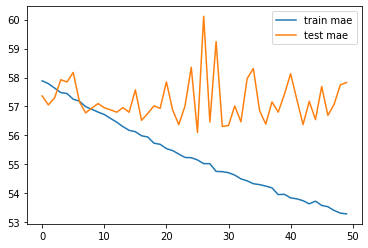

In [266]:
print(model.evaluate(x_test, y_test))

train_acc = history.history['loss']
test_acc = history.history['val_loss']
x = np.arange(len(train_acc))
plt.plot(x, train_acc, label = 'train mae')
plt.plot(x, test_acc, label = 'test mae')
plt.legend() #グラフの線の説明を表示

In [267]:
#与えられたデータに対する予測

pred = model.predict(x_test).flatten()
compare = pd.DataFrame(np.array([y_test, pred]).T)
compare.columns = ['正解','予測値']
compare

,正解,予測値
0,79.0,98.075966
1,59.0,104.197723
2,60.0,68.824417
3,56.0,81.014854
4,190.0,169.958969
...,...,...
11112,10.0,631.166382
11113,500.0,118.619705
11114,248.0,217.044769
11115,119.0,135.037292


In [270]:
test_x

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,beds_per_room,review_date,last_review_date,keep_date,rating
55583,1.320992,1.313891,0.152813,0.861606,0.230543,1.010455,-2.786012,0.601880,0.717216,0.070888,-1.429090,0.345621,1.010358,1.676347,0.565312,1.270498,0.982603,-1.518123,0.980730,1.303661,-0.519029,-0.850673,-1.103281,0.193582,0.337367,0.288706,-0.161234,0.691272
55584,-0.072041,-0.404204,0.152813,-0.311913,-0.566820,-0.159508,-0.247604,0.601880,0.582857,0.070888,0.683896,0.345621,0.005321,-0.596535,0.559514,-1.415911,-1.196481,1.200828,-0.446769,1.071570,0.757053,-0.850673,1.184133,-0.346721,0.549544,0.487038,-0.163282,-0.551787
55585,-0.536385,-0.404204,0.152813,-1.485432,-0.566820,-1.329472,0.598532,-1.661461,-1.885651,0.070888,0.683896,0.345621,-0.998002,-0.596535,-1.913205,0.738466,0.849490,1.316635,-0.552510,-0.669117,0.000000,0.952445,-0.869341,-0.526822,-1.572961,-1.589575,-0.691762,0.000000
55586,0.392303,-0.404204,0.152813,-0.311913,0.230543,1.010455,0.598532,-1.661461,-1.885651,0.070888,0.683896,0.000000,-0.538570,-0.596535,-1.913205,0.725667,0.850186,-1.508053,-0.552510,-0.669117,0.000000,-0.850673,-0.869341,-0.166620,-1.609123,-1.623436,-0.691762,0.000000
55587,-0.072041,0.454844,0.152813,-0.311913,0.230543,1.010455,-0.247604,0.601880,0.438028,0.070888,0.683896,0.345621,0.021718,-0.596535,0.428052,-1.394403,-1.198416,1.387126,-0.393899,1.883890,-0.263813,-0.850673,1.210126,-0.166620,0.365780,0.366449,0.141925,-0.512587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,0.392303,-0.404204,0.152813,0.861606,0.230543,1.010455,0.598532,0.601880,-1.885651,0.070888,0.683896,0.345621,-2.506618,-0.596535,-1.913205,0.743016,0.849688,-0.531245,-0.552510,-0.669117,0.000000,-0.850673,-0.869341,0.193582,-1.179604,-1.221244,-0.691762,0.000000
74107,-0.536385,-0.404204,0.152813,0.861606,-0.566820,-1.329472,-1.939876,-1.661461,0.717318,0.070888,-1.429090,0.345621,1.478821,-0.596535,0.558267,1.136303,0.217713,-0.224104,-0.314594,-0.669117,-0.519029,-0.850673,0.404333,-0.166620,0.289028,0.183320,-0.517651,-0.446049
74108,0.856648,0.454844,0.152813,0.861606,0.230543,-1.329472,-1.939876,0.601880,-1.885651,0.070888,-1.429090,0.345621,0.005270,-0.596535,-1.913205,1.132143,0.216052,-1.593649,-0.552510,1.303661,0.000000,-0.850673,0.404333,0.193582,-1.825728,-1.826260,-0.691762,0.000000
74109,-0.536385,-0.404204,0.152813,-0.311913,0.230543,1.010455,0.598532,0.601880,0.577044,0.070888,-1.429090,0.345621,-0.024245,-0.596535,0.559596,0.760595,0.850035,-0.898806,-0.446769,-0.669117,0.119012,-0.850673,-0.895334,-0.166620,0.566518,0.547850,0.103006,-0.556945


In [268]:
pred_nn = model.predict(test_x.values).flatten()

In [278]:
# アンサンブル
pred_final = (pred_lgb_opt * 0.8 + pred_nn * 0.2)

In [279]:
pred_final

array([238.20326, 128.18605, 113.27356, ..., 249.34664, 124.99474,
        46.5797 ])

In [280]:
pd.DataFrame(pred_final).to_csv("../output/prediction_ensemble_lgbm_nn.csv")

In [ ]:
# NAの数カウント